In [45]:
from omegaconf import OmegaConf
import numpy as np
import os
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb
# Imports of own files
import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics


In [2]:
run_id = "icey2rjl"
entity = "haraghi"
project = "DGCNN"
pre_cfg_path = "cfg_folder/EST_NASL_64.yaml"

In [3]:
api = wandb.Api()
runs = api.runs(
    path=osp.join(entity,project),
    filters={"config.wandb.experiment_name": {"$regex": "^.*EST 64.*HPC.*$"}}
)
run_id = runs[0].id
print(run_id)

vwoabjqc


In [5]:
run = wandb.init()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [6]:
checkpoint_reference = osp.join(entity, project, "model-" + run_id+":best")
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()


config = api.run(osp.join(entity, project, run_id)).config
cfg = OmegaConf.create(config)

wandb: Downloading large artifact model-vwoabjqc:best, 244.51MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


In [7]:
cfg_file = OmegaConf.load(pre_cfg_path)
cfg = OmegaConf.merge(cfg_file, cfg)

In [23]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation

In [8]:
# Seed everything. Note that this does not make training entirely
# deterministic.
pl.seed_everything(cfg.seed, workers=True)


# Create datasets using factory pattern
gdm = GraphDataModule(cfg)
cfg.dataset.num_classes = gdm.num_classes

Global seed set to 0


In [32]:
# test_file_list = []
# for data in gdm.test_dataloader():
#     test_file_list.extend(data.file_id)

In [23]:
# train_file_list = []
# for data in gdm.train_dataloader():
#     train_file_list.extend(data.file_id)

In [25]:
# val_file_list = []
# for data in gdm.val_dataloader():
#     val_file_list.extend(data.file_id)

In [43]:
# print(len(train_file_list))
# print(len(test_file_list))
# print(len(val_file_list))

75600
15120
10080


In [44]:
# print(set(test_file_list).intersection(set(val_file_list)))
# print(set(test_file_list).intersection(set(train_file_list)))
# print(set(val_file_list).intersection(set(train_file_list)))

set()
set()
set()


In [9]:
model = model_factory.factory(cfg)

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
 
runner = Runner.load_from_checkpoint(osp.join(artifact_dir,"model.ckpt"), cfg=cfg, model=model)

/home/hesam/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hesam/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
trainer = pl.Trainer(
    max_epochs=cfg.train.epochs,
    enable_progress_bar=True,
    # Use DDP training by default, even for CPU training
    # strategy="ddp_notebook",
    devices=torch.cuda.device_count(),
    accelerator="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hesam/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [11]:
trainer.test(runner, datamodule=gdm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 945/945 [00:47<00:00, 19.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9921296238899231
        test/loss          0.024719521403312683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.024719521403312683, 'test/acc': 0.9921296238899231}]

In [12]:
dl = DataLoader(
            create_dataset(
                dataset_path = gdm.dataset_path,
                dataset_name  = gdm.dataset_name,
                dataset_type = 'test',
                transform = gdm.transform_dict['test'],
                num_workers=gdm.num_workers
            ),
            batch_size=16,
            shuffle=False,
            num_workers=gdm.num_workers,
        )
ds = create_dataset(
        dataset_path = gdm.dataset_path,
        dataset_name  = gdm.dataset_name,
        dataset_type = 'test',
        transform = gdm.transform_dict['test'],
        num_workers=gdm.num_workers
    )

In [51]:
torch.cuda.empty_cache()
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=cfg.dataset.num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = runner.model.to(device)
model.eval()

correct = 0
total = 0

y=torch.tensor([],device=device)
y_hat=torch.tensor([],device=device)
preds = []
targets = []
files = []
with torch.no_grad():
    for data in tqdm(gdm.test_dataloader()):
        files.extend(data.file_id)
        targets.append(data.y)
        data = data.to(device)
        y = torch.cat((y,data.y))
        out, _ = model(data)
        preds.append(out.clone().detach().cpu())
        label = torch.argmax(out, dim=1) 
        y_hat = torch.cat((y_hat,label))
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
print(correct/total)    

100%|██████████| 945/945 [00:43<00:00, 21.58it/s]

tensor(0.9924, device='cuda:0')


In [68]:
preds_ = torch.stack(preds,dim=0).permute(0,2,1)
targets_ = torch.stack(targets,dim=0)

In [79]:
metrics = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=cfg.dataset.num_classes) 
metrics.update(preds_, targets_)

confusion_matrix_computed = metrics.compute().detach().cpu().numpy().astype(int)

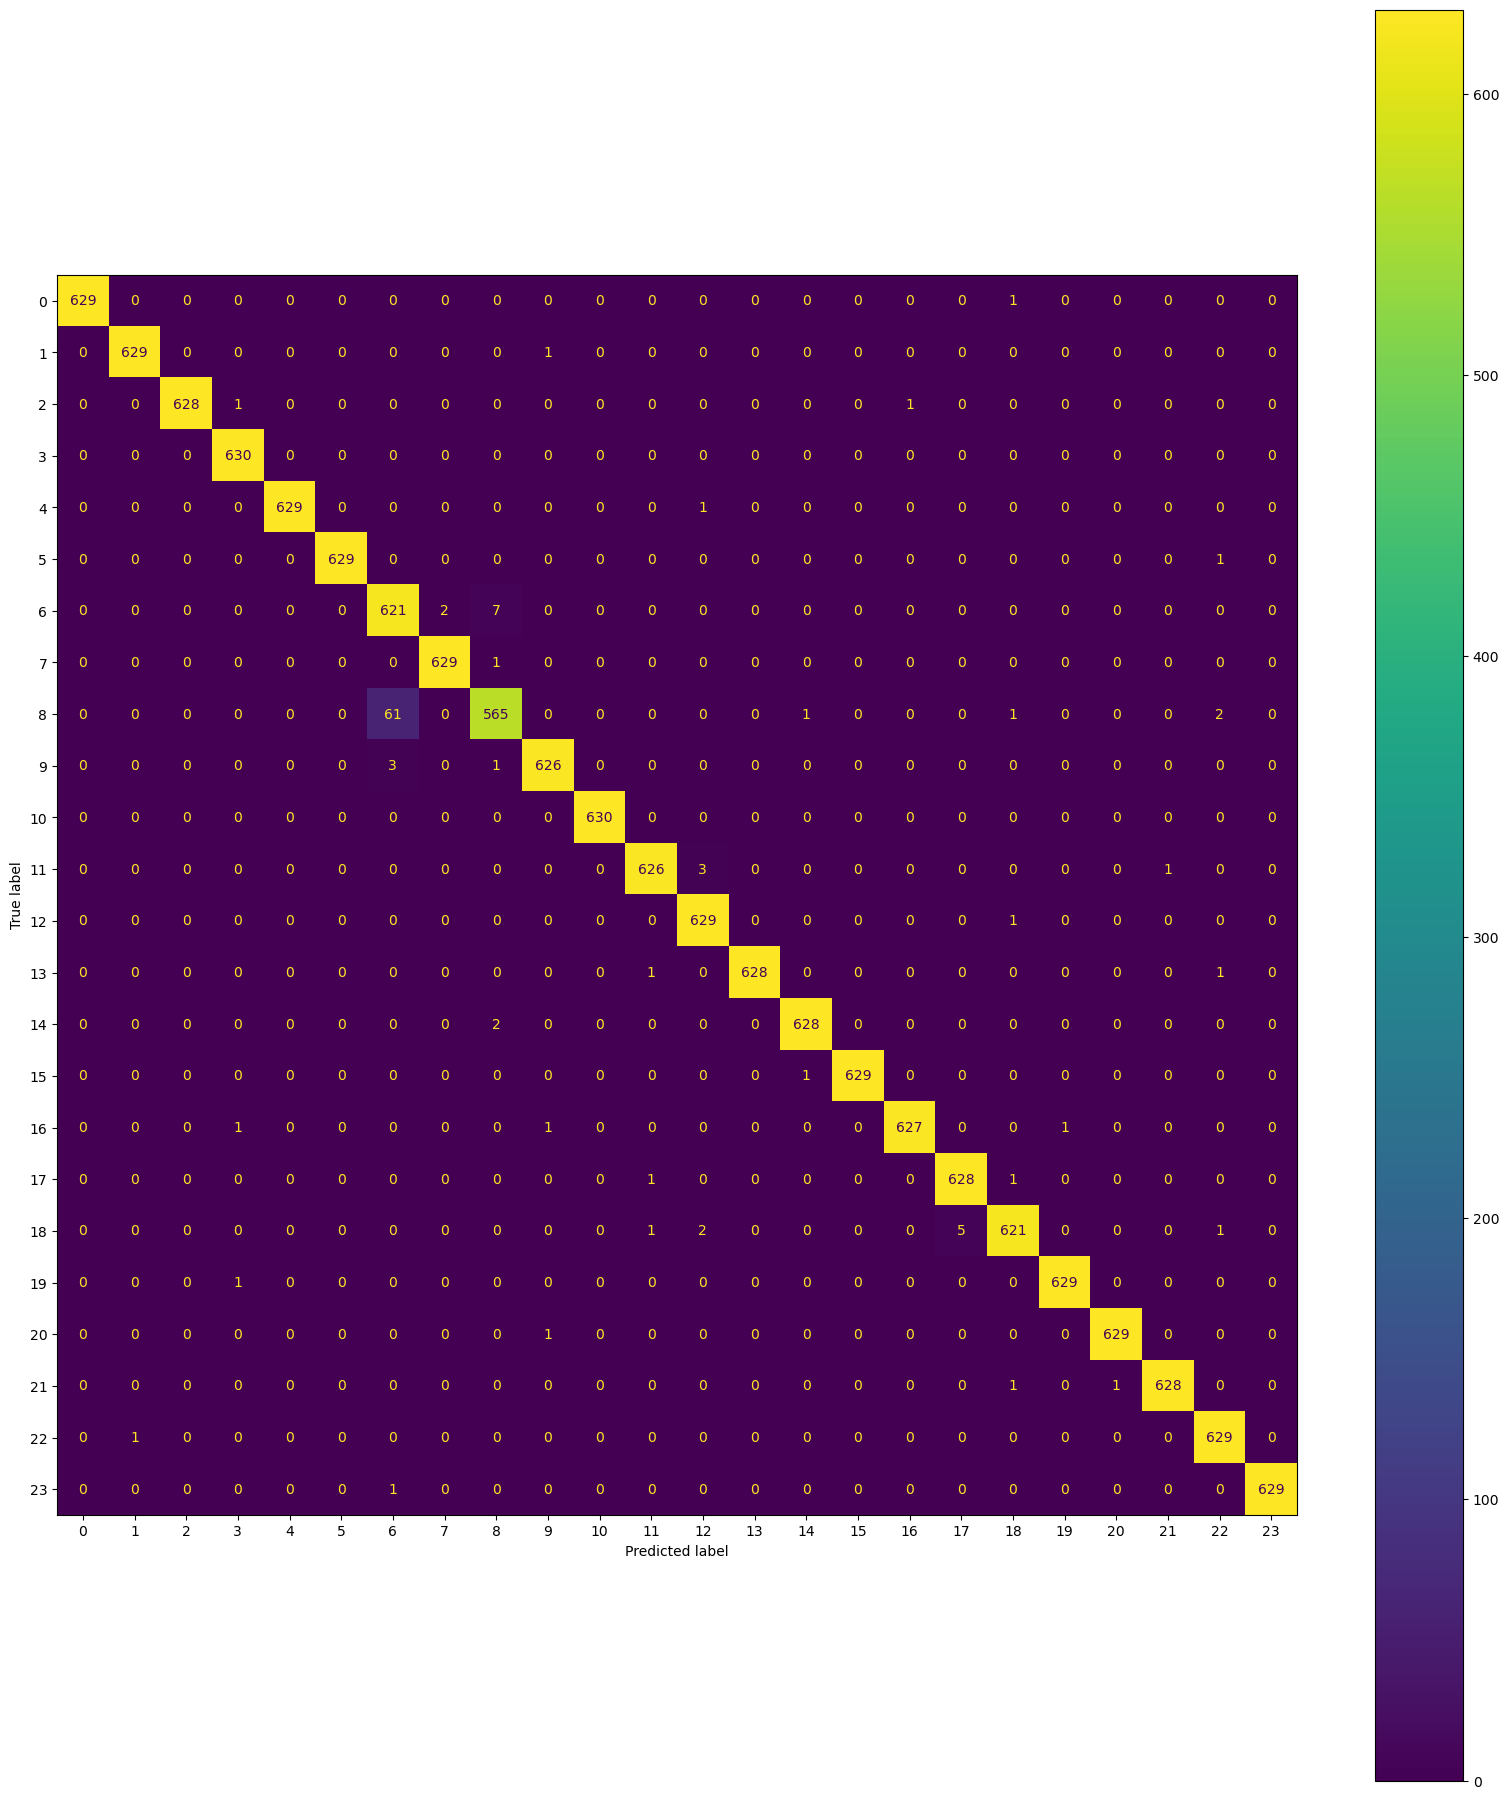

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_computed)
fig, axs = plt.subplots(1, 1, figsize=(20,23))
disp.plot(ax=axs)
plt.show()

In [31]:
name2ind = {d.file_id: i  for i, d in enumerate(ds)}

In [40]:
idx = torch.randint(0, len(ds),(1,))
idx = (name2ind['u_1656.mat'],)
correct = 0
total = 0

y = []
y_hat = []
model.eval()

with torch.no_grad():
    for ii in tqdm(range(1000)):
        
        data = ds[idx][0]
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device)
        
        y.append(data.y.cpu().item())
        out, _ = model(data)
        label = torch.argmax(out, dim=1)
        y_hat.append(label.cpu().item())
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
    # loss = runner.loss_fn(y_hat, y)
print(data.file_id)    
print(correct/total)
print(np.unique(np.array(y_hat)))

100%|██████████| 1000/1000 [00:11<00:00, 86.28it/s]

u_1656.mat
tensor(0.9970, device='cuda:0')
[16 18 19]


In [19]:

ys = [d.y.clone().detach().item() for d in ds]
ys = np.array(ys)

# count the number of happening of each value in the numpy array
unique, counts = np.unique(ys, return_counts=True)

print(counts)

[630 630 630 630 630 630 630 630 630 630 630 630 630 630 630 630 630 630
 630 630 630 630 630 630]


0


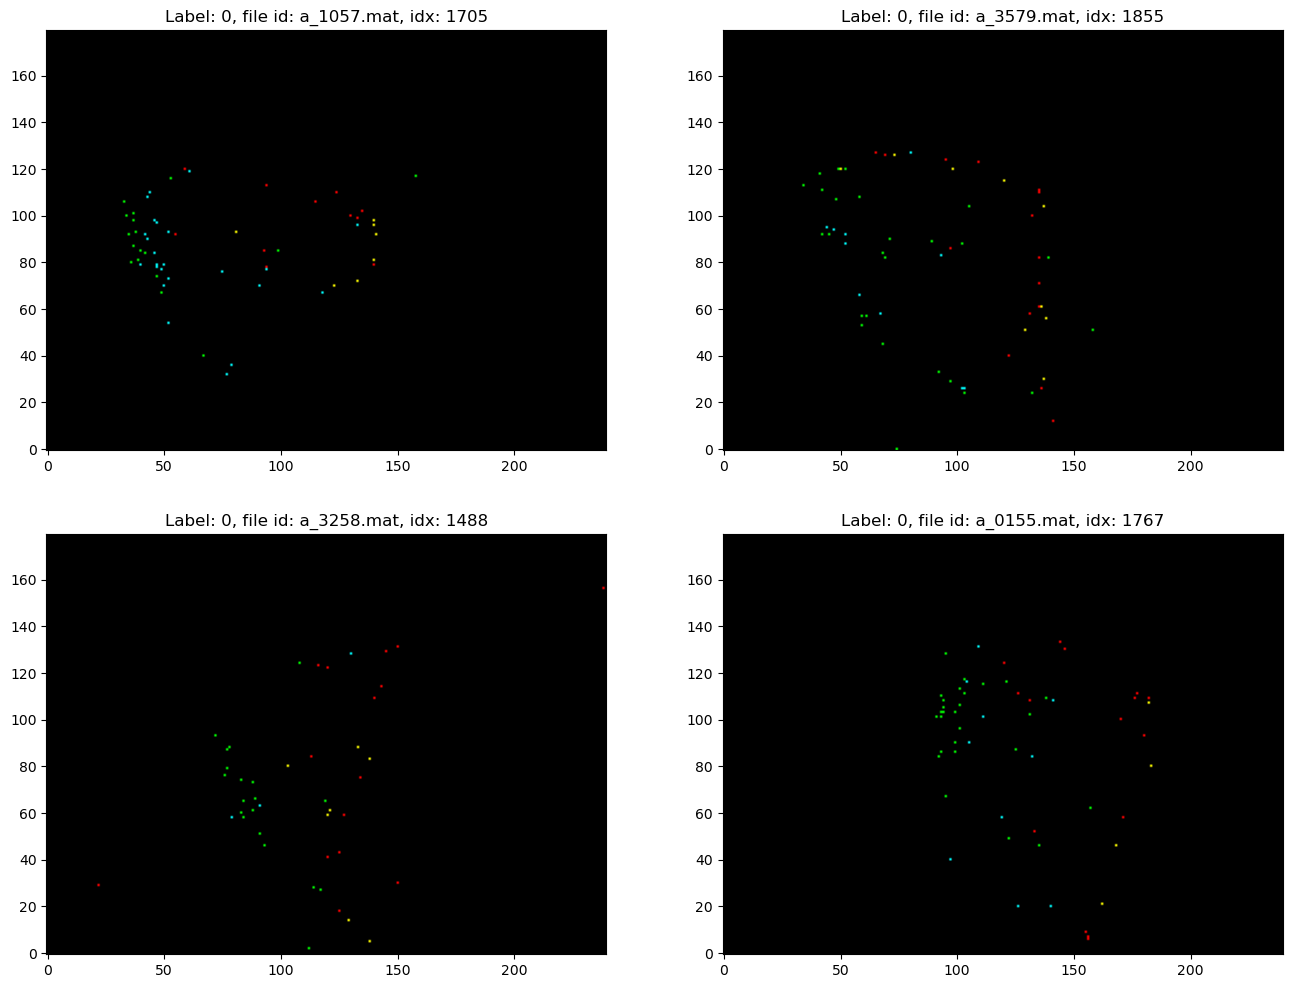

1


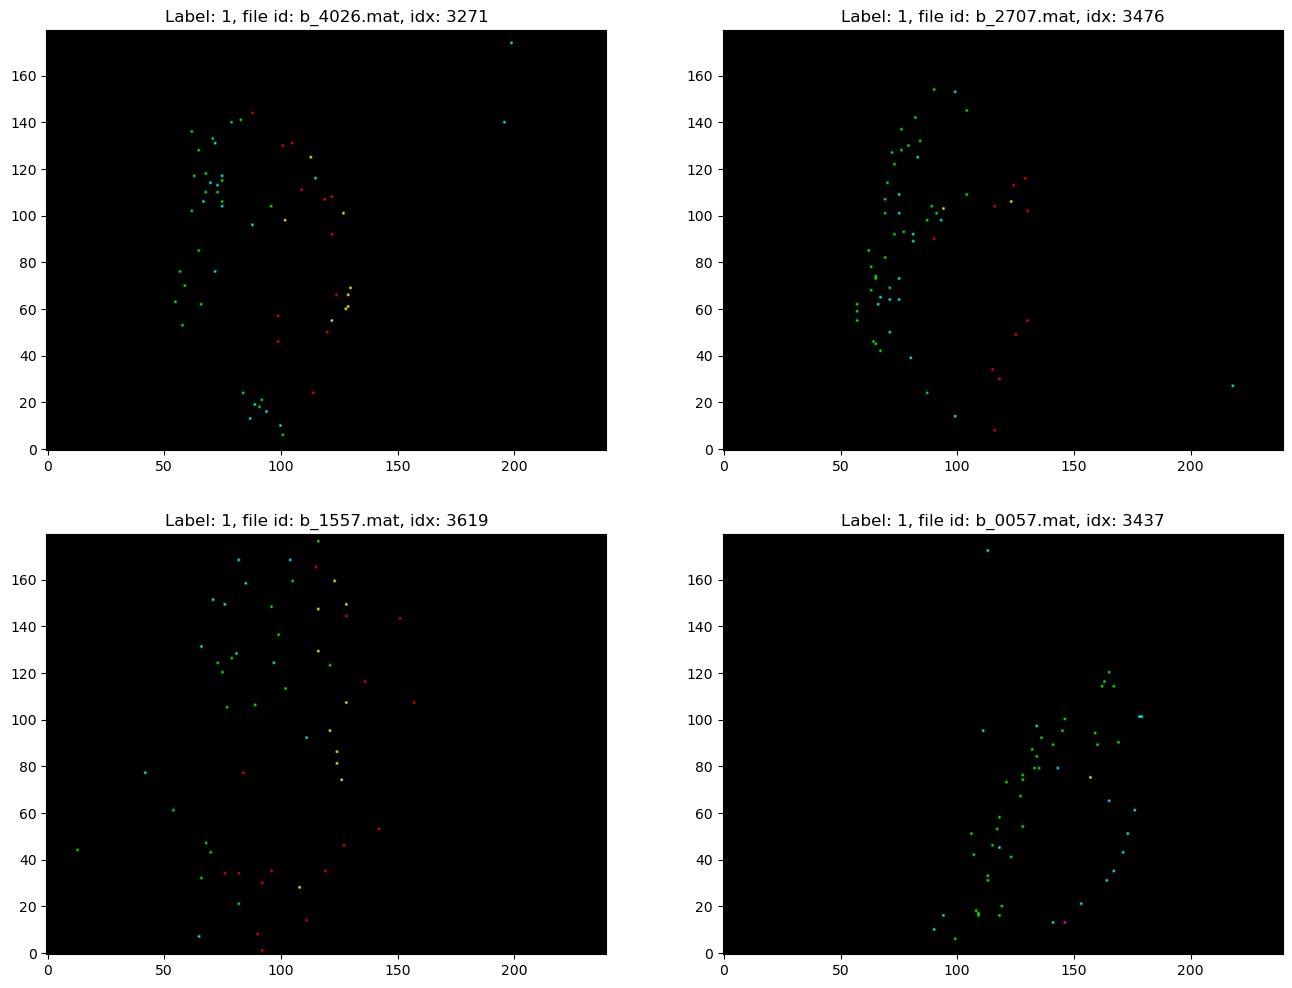

2


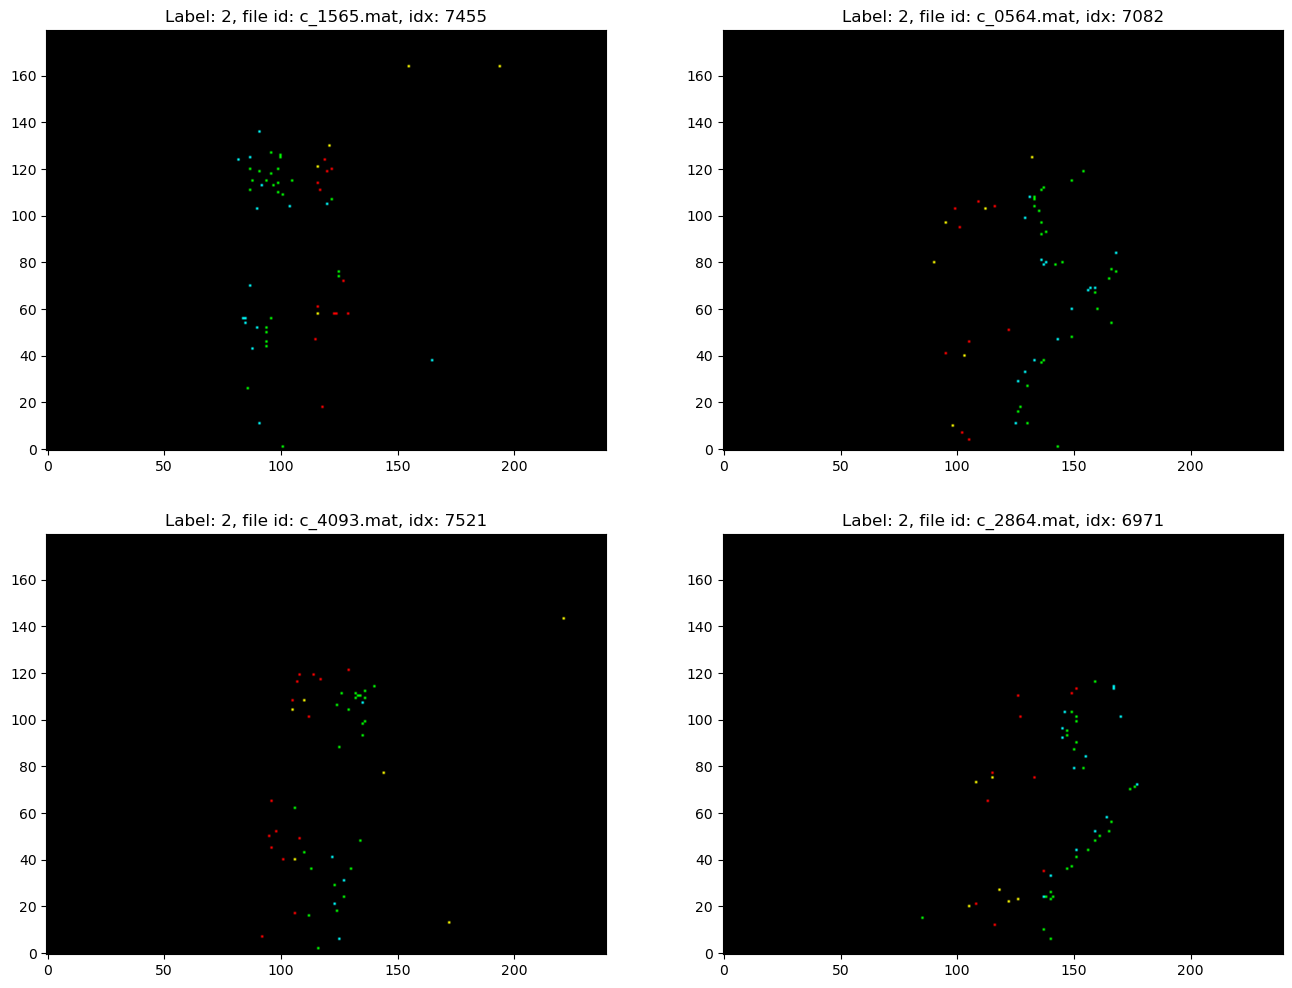

3


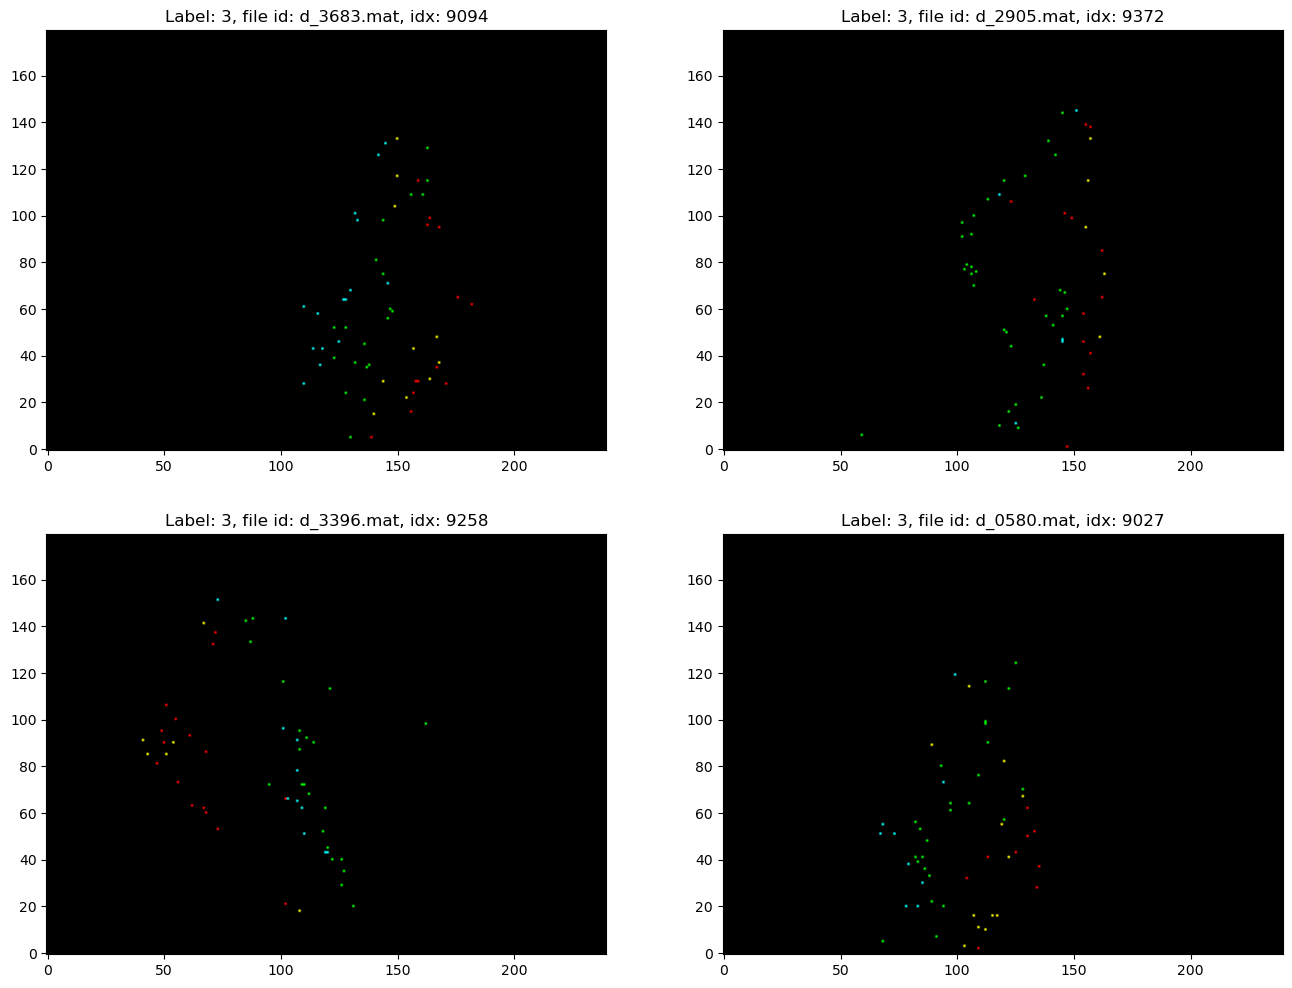

4


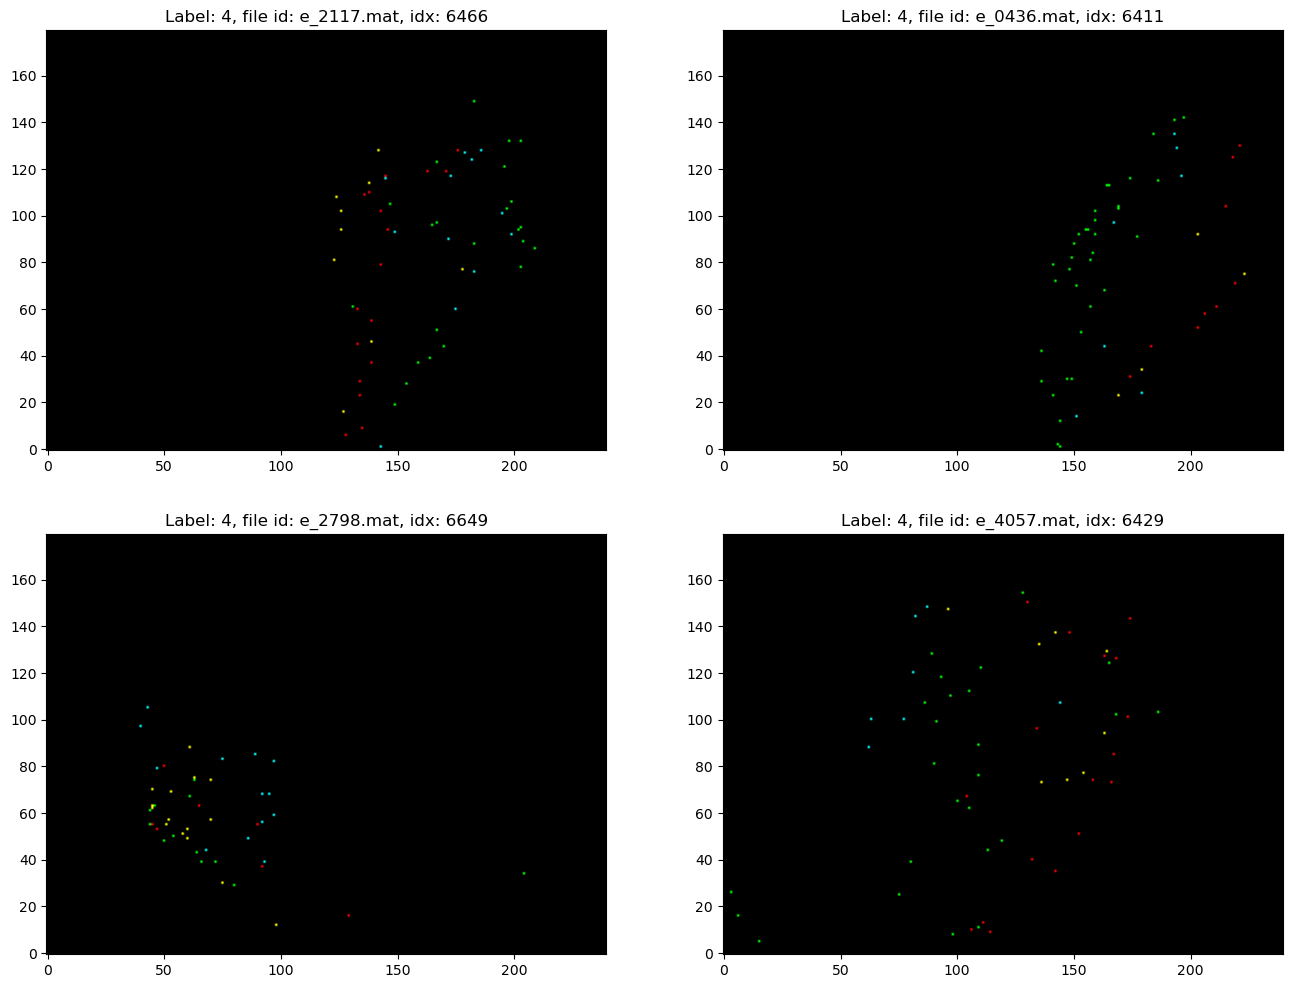

5


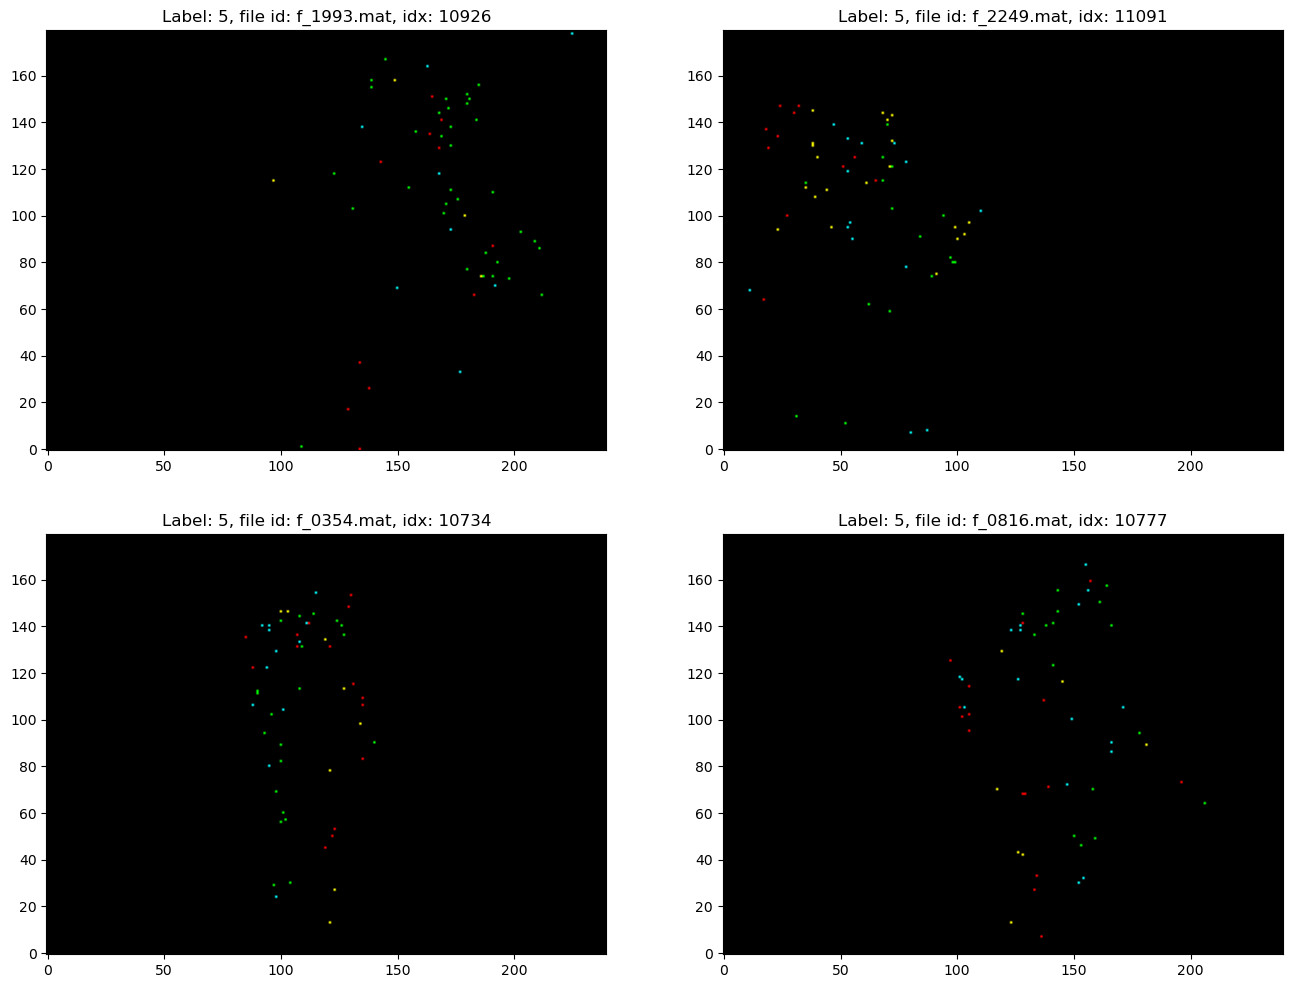

6


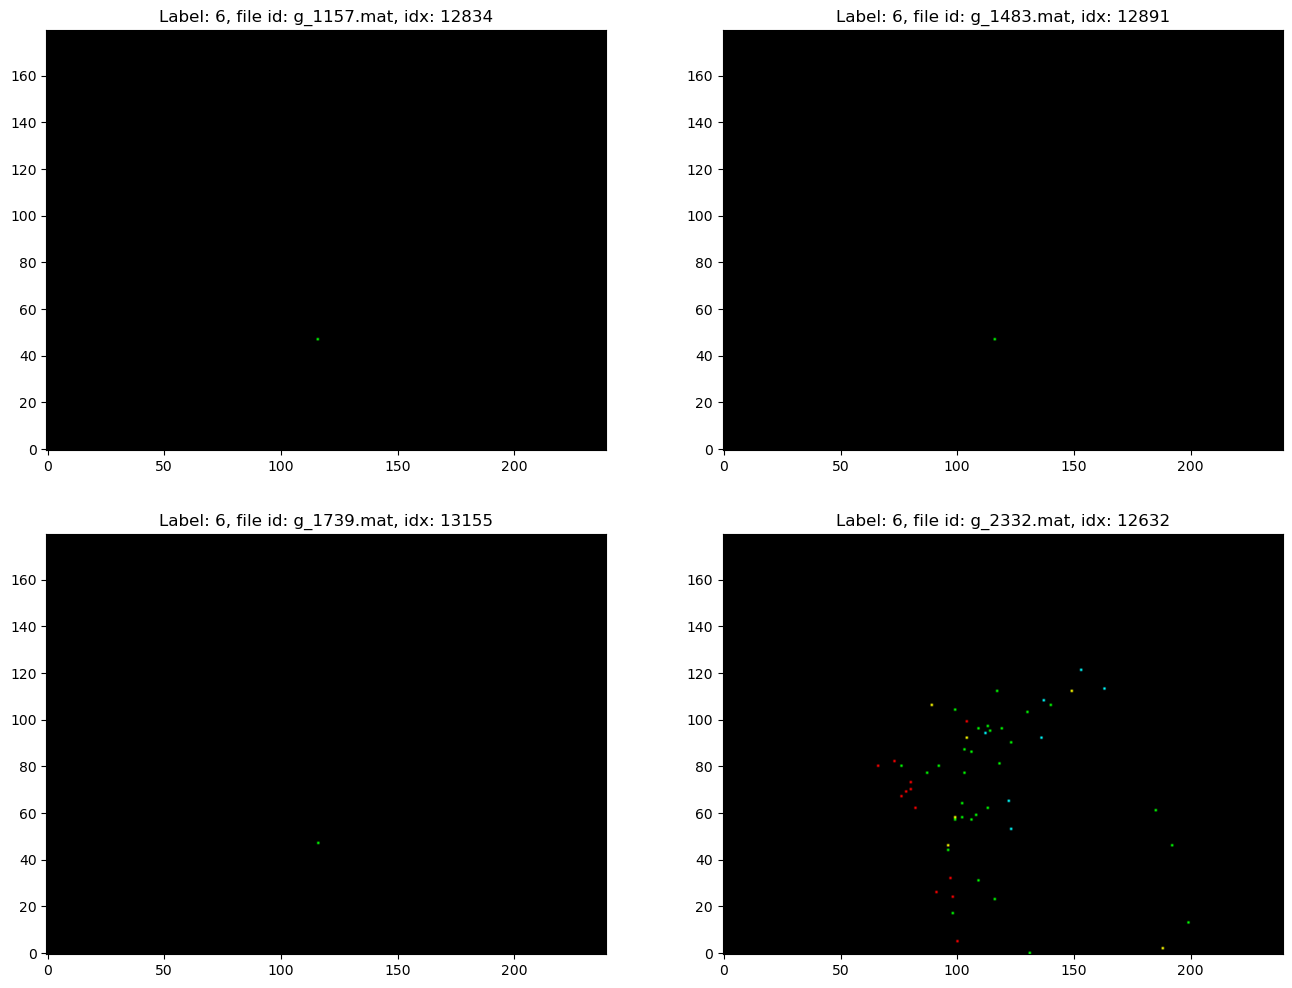

7


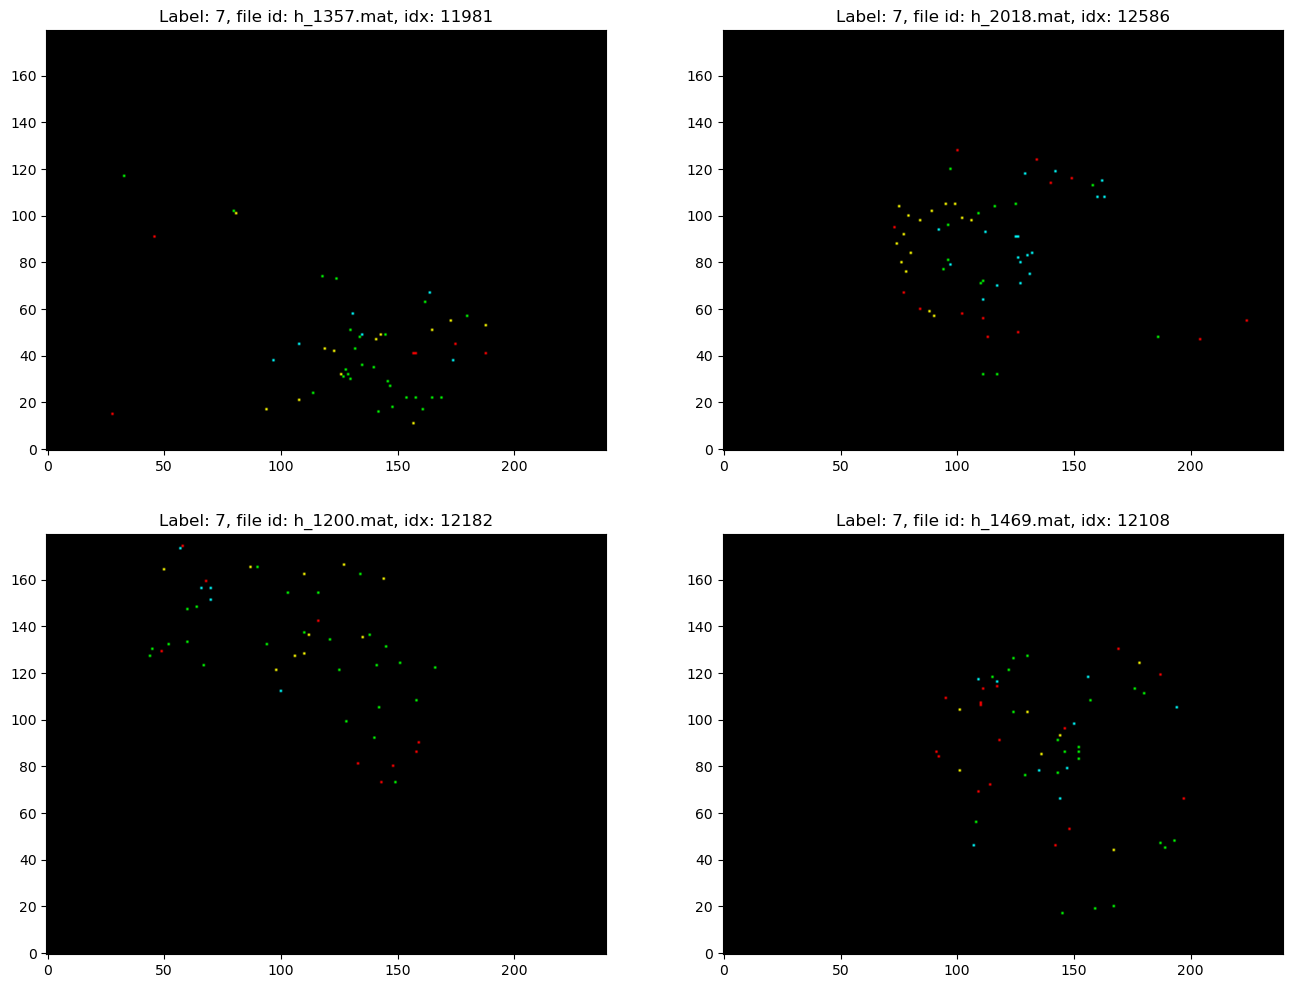

8


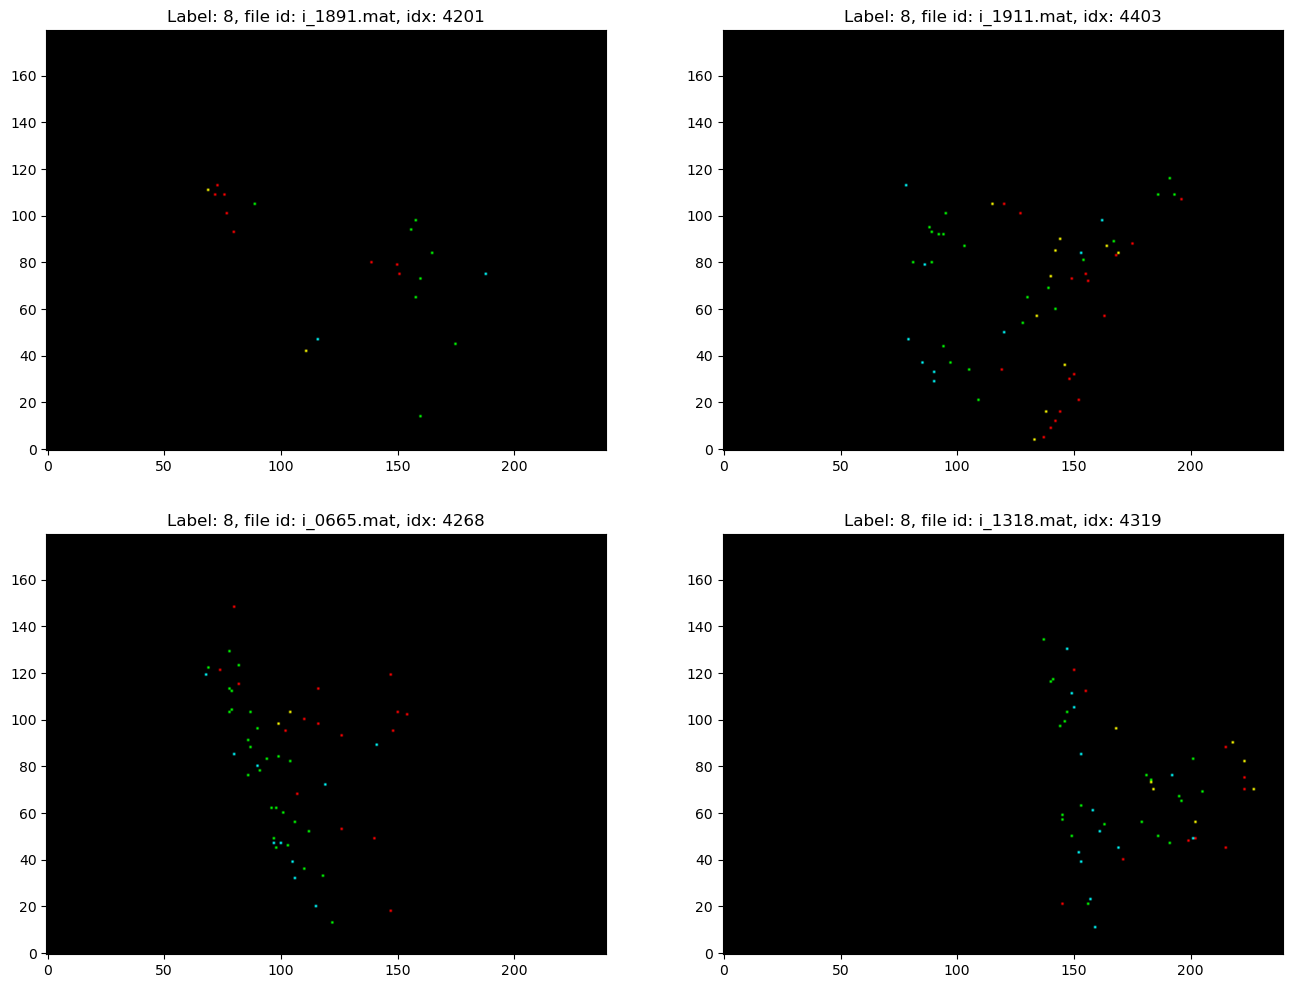

9


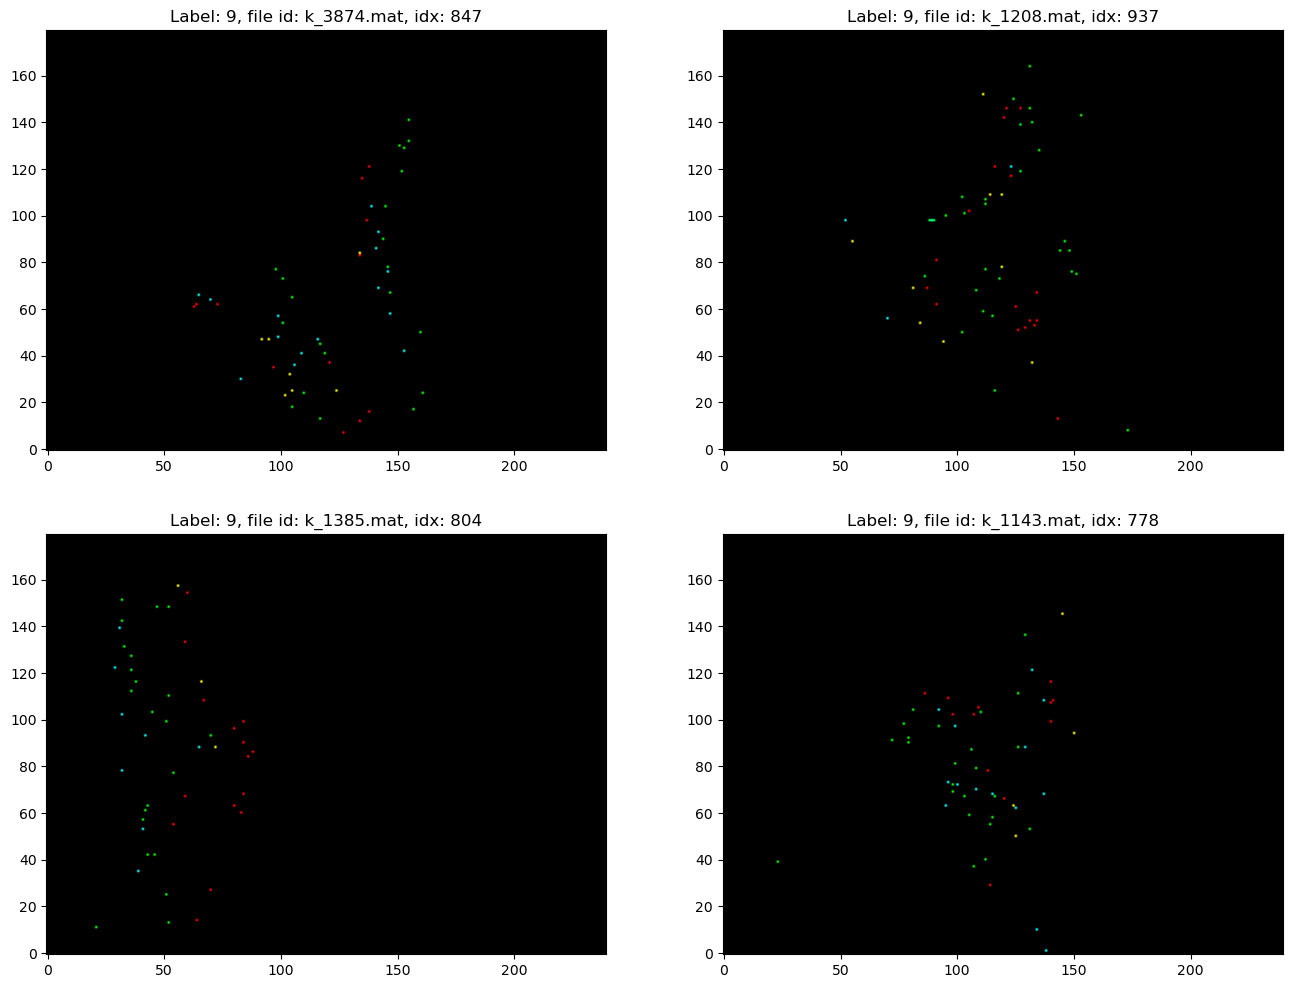

10


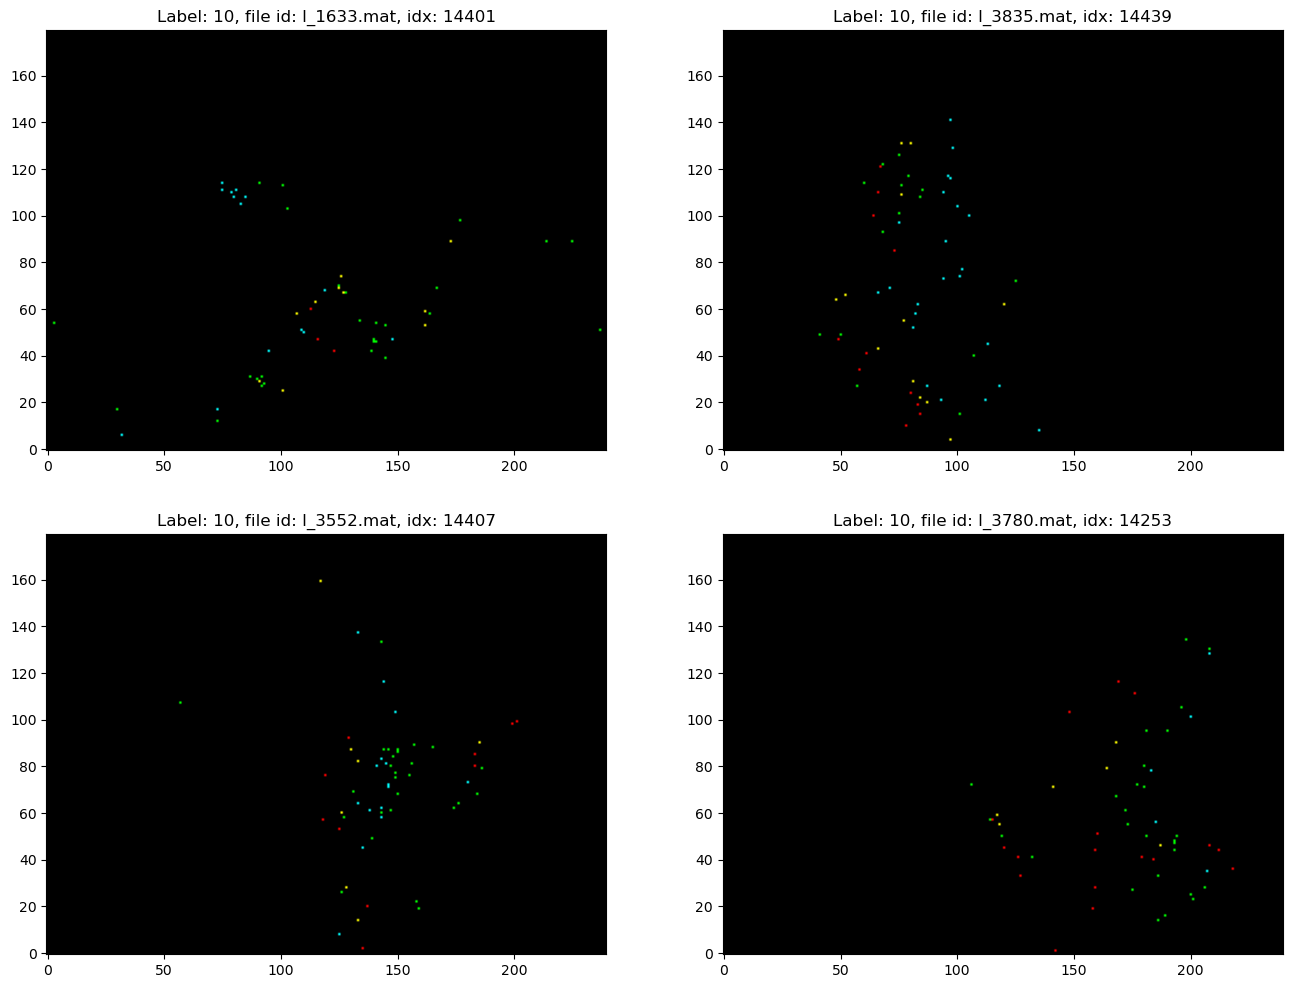

11


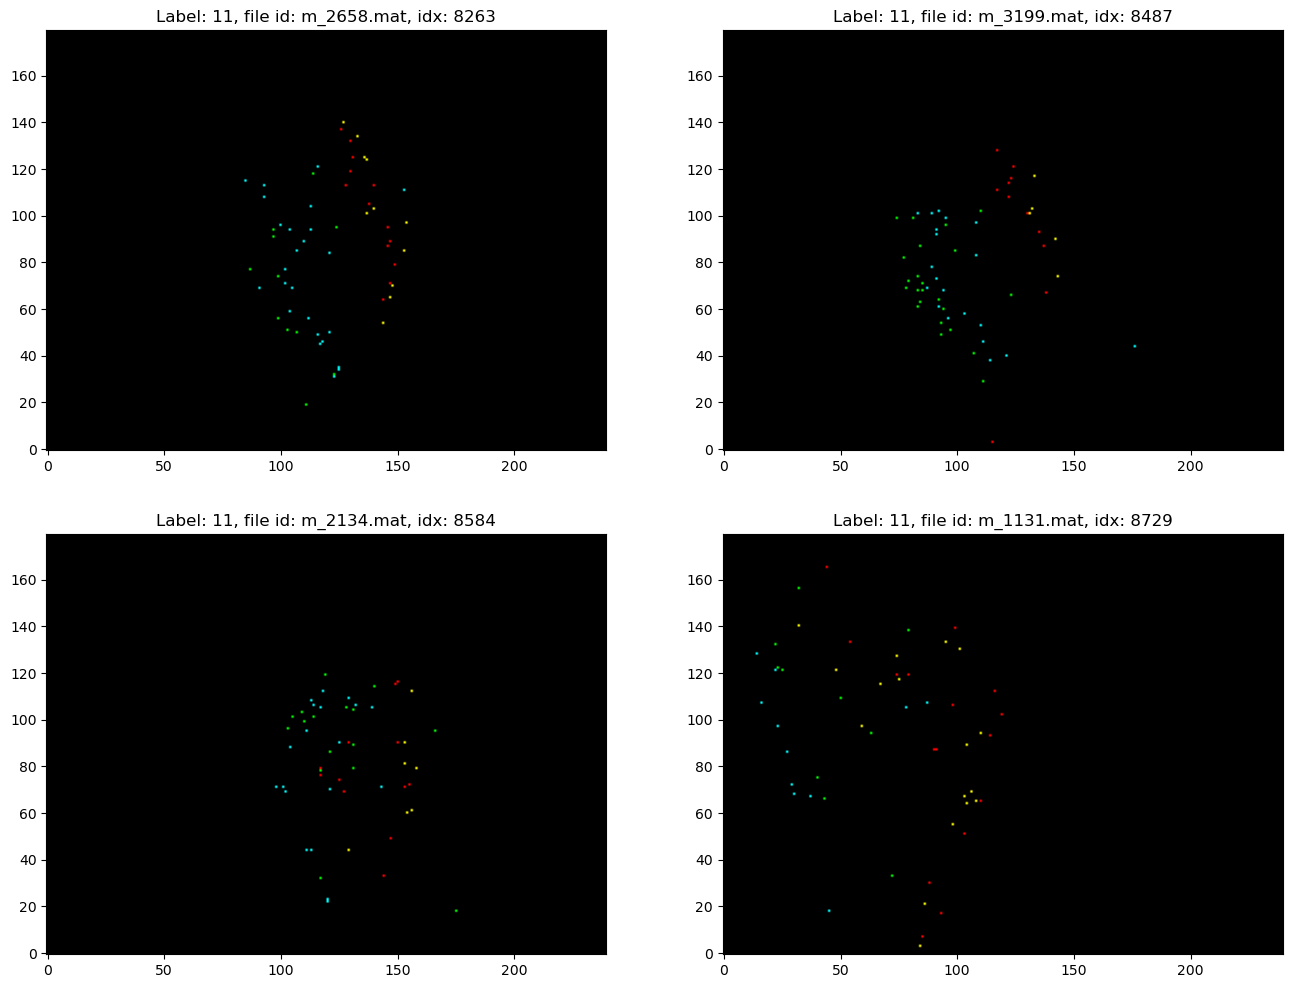

12


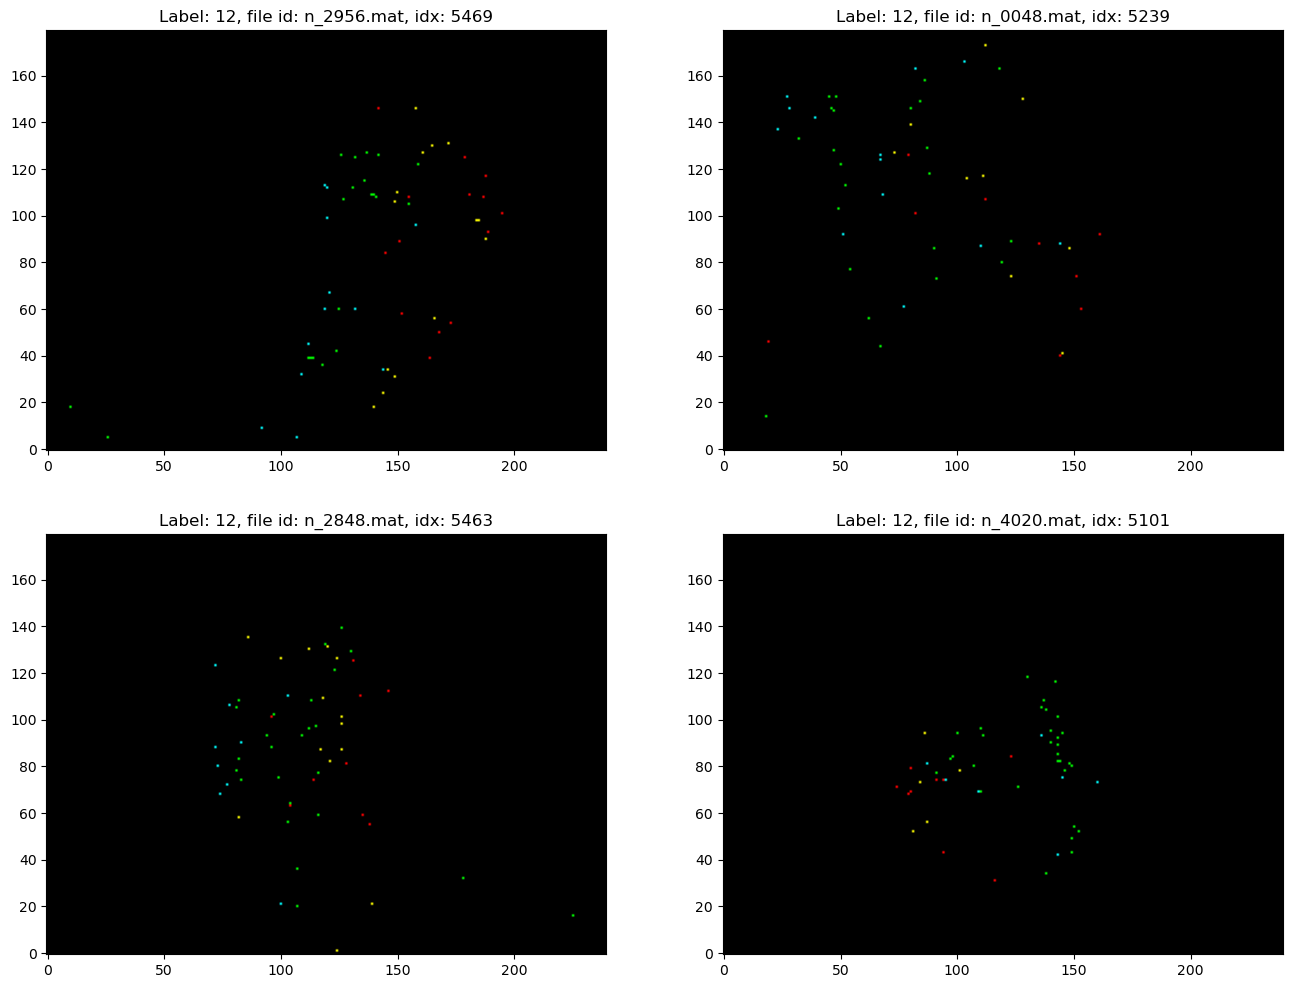

13


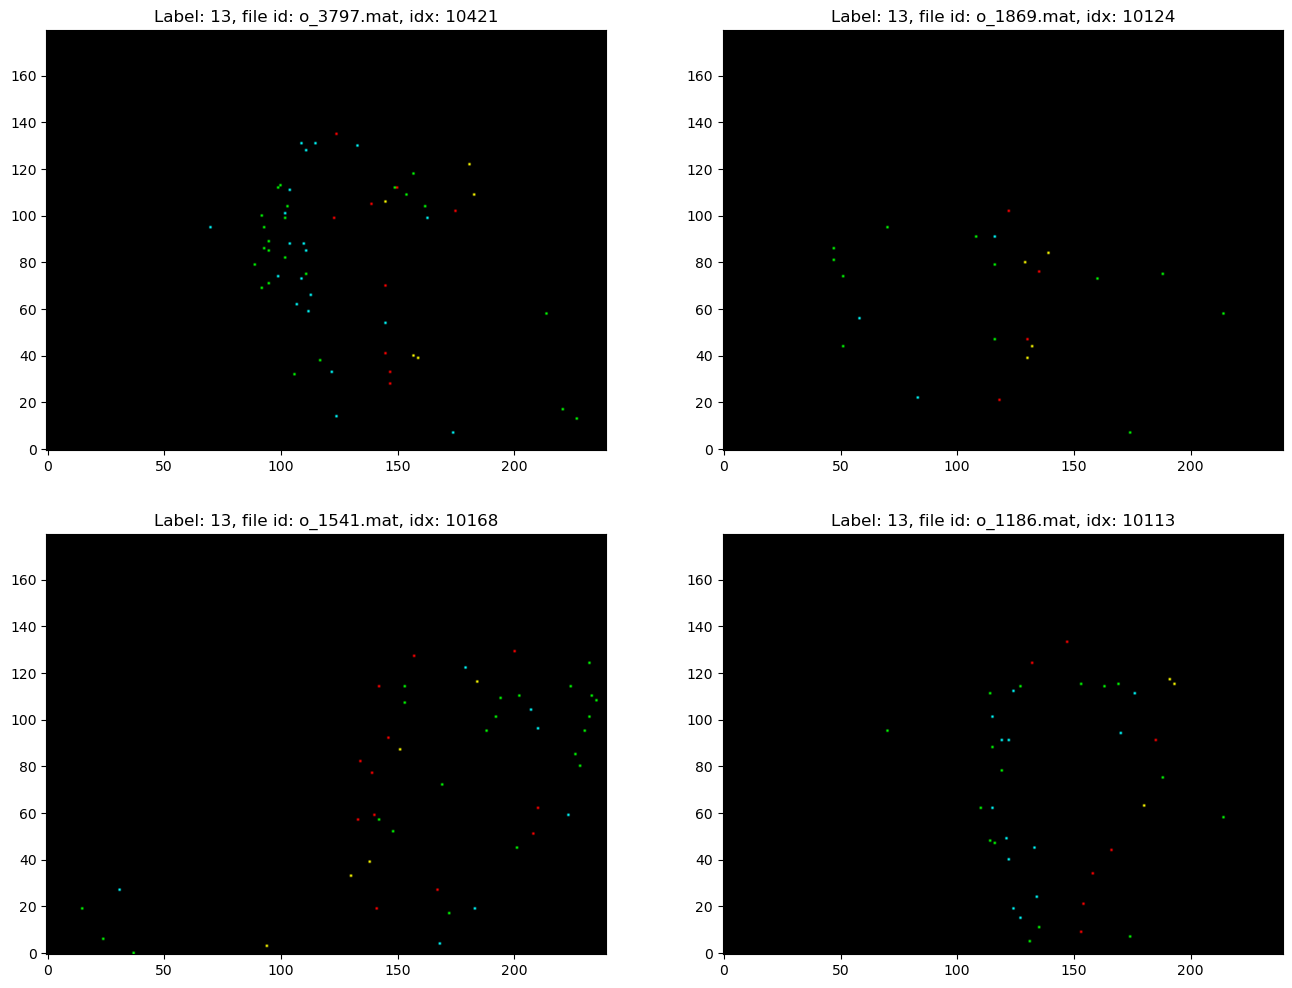

14


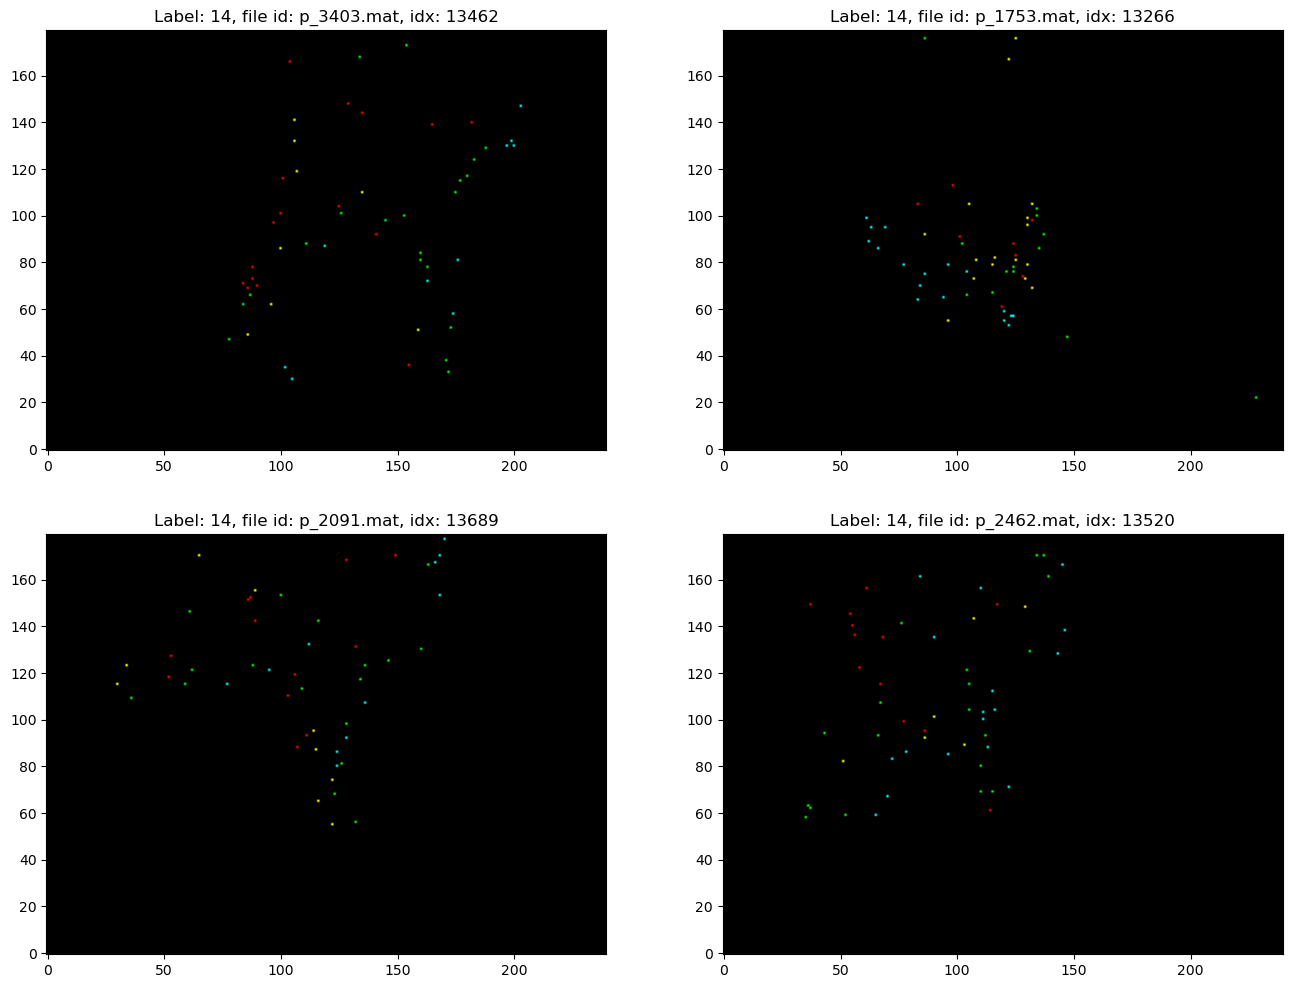

15


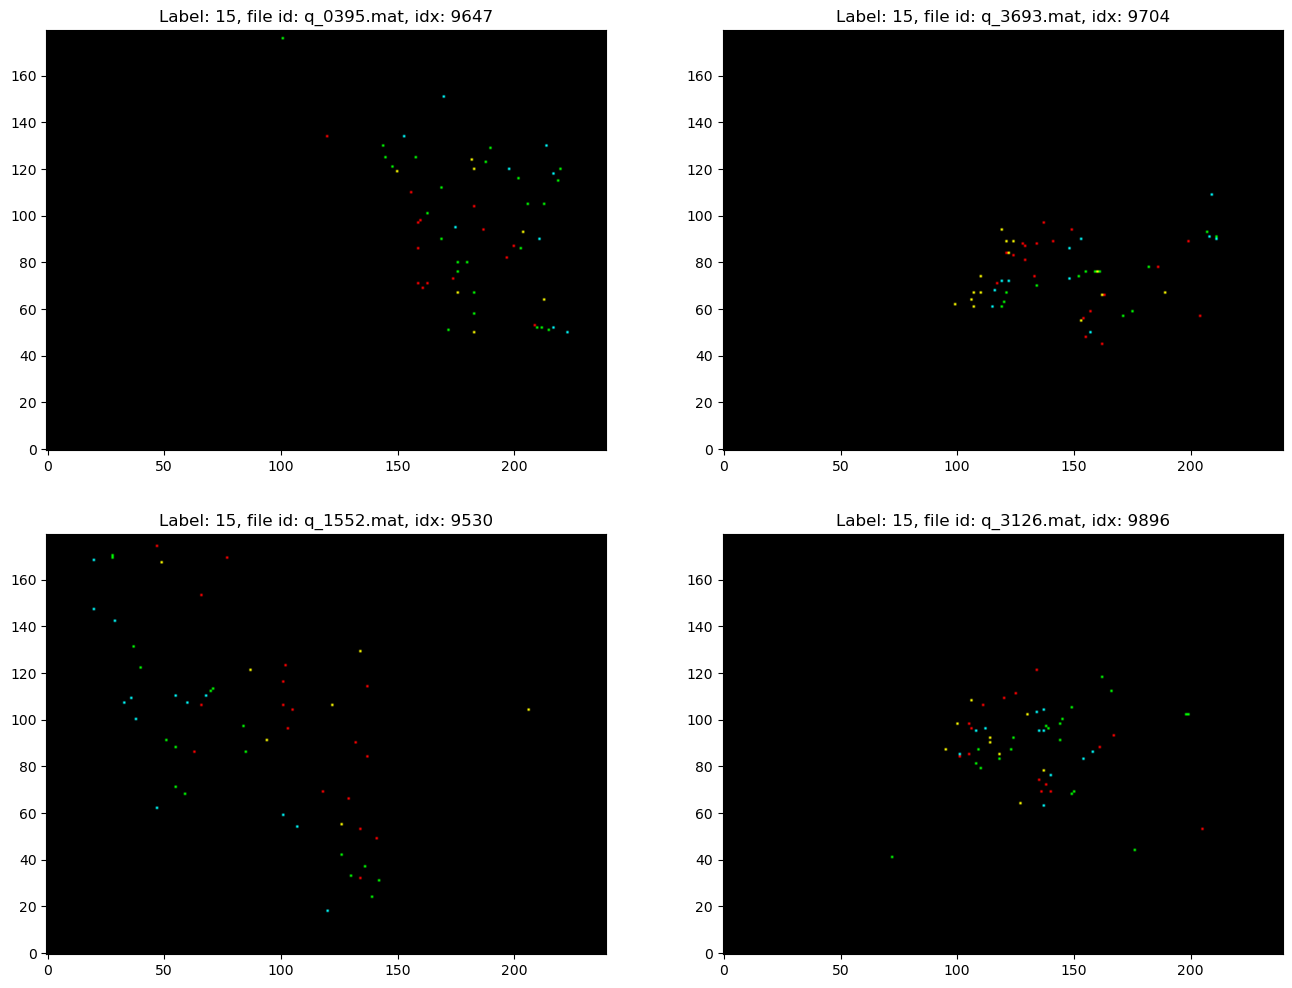

16


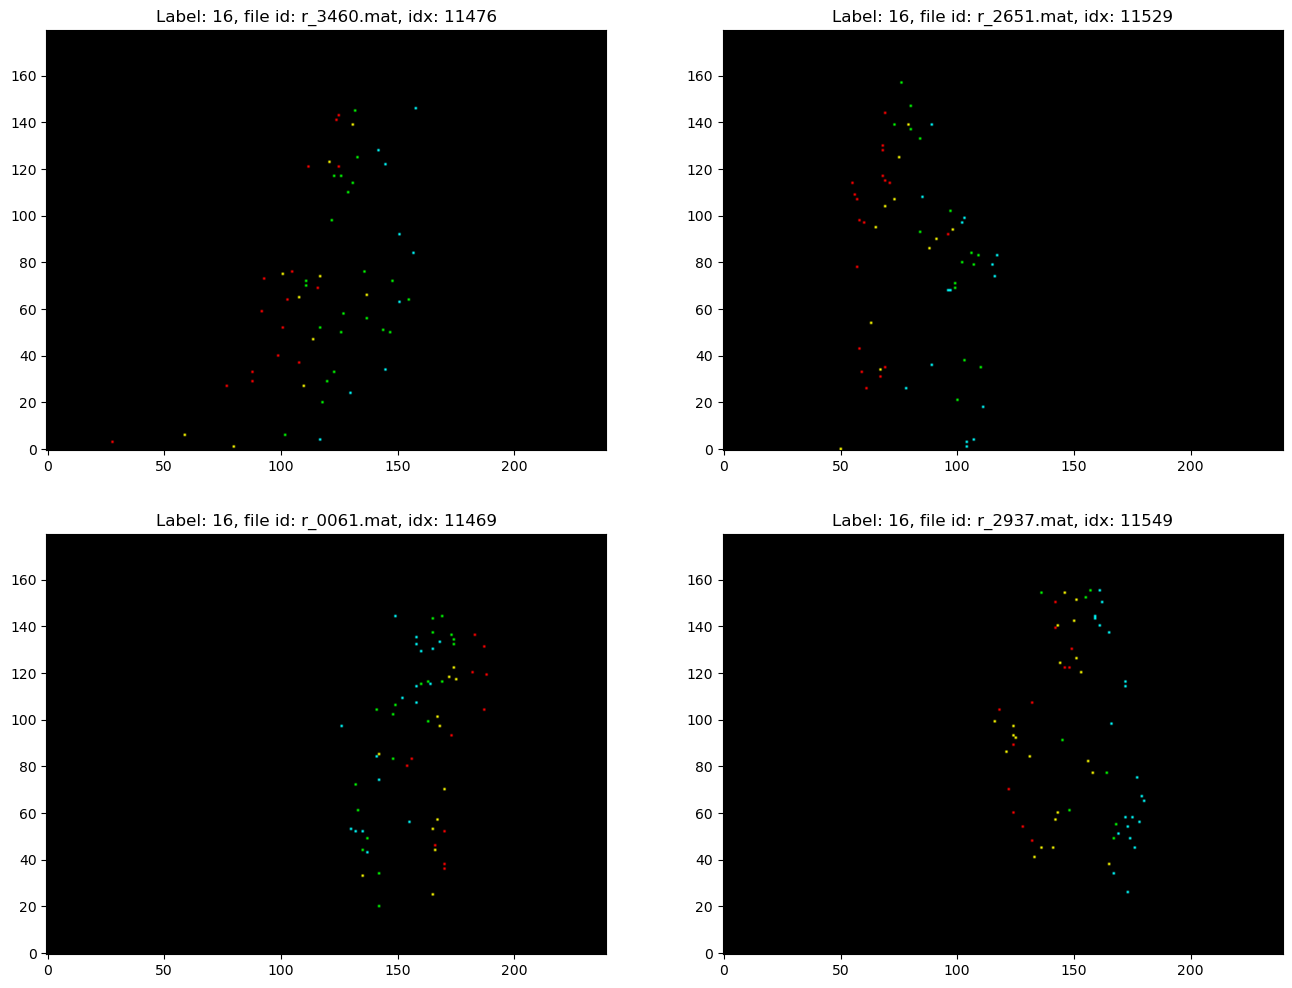

17


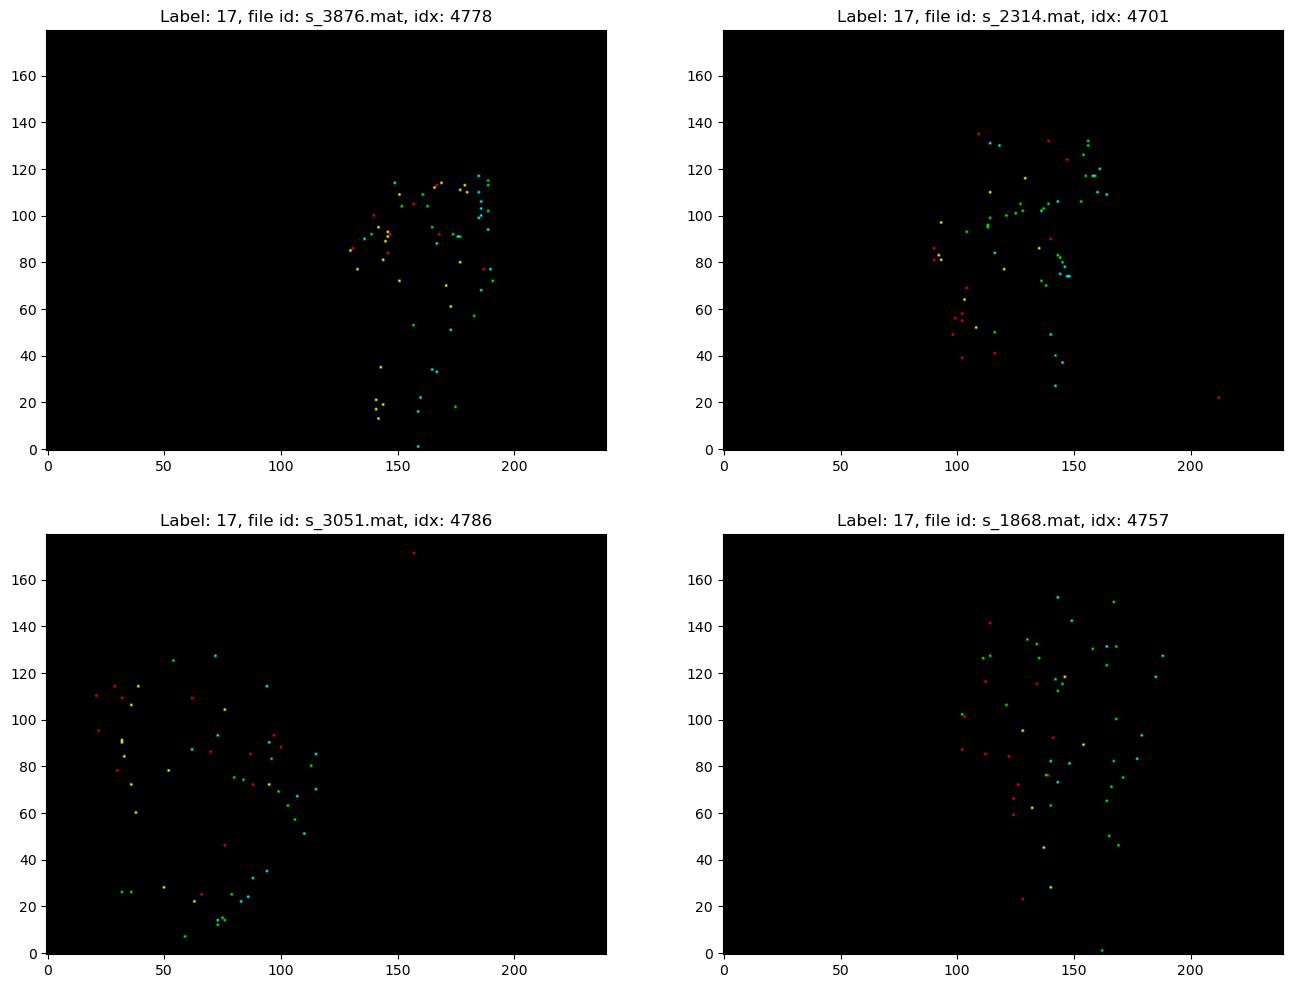

18


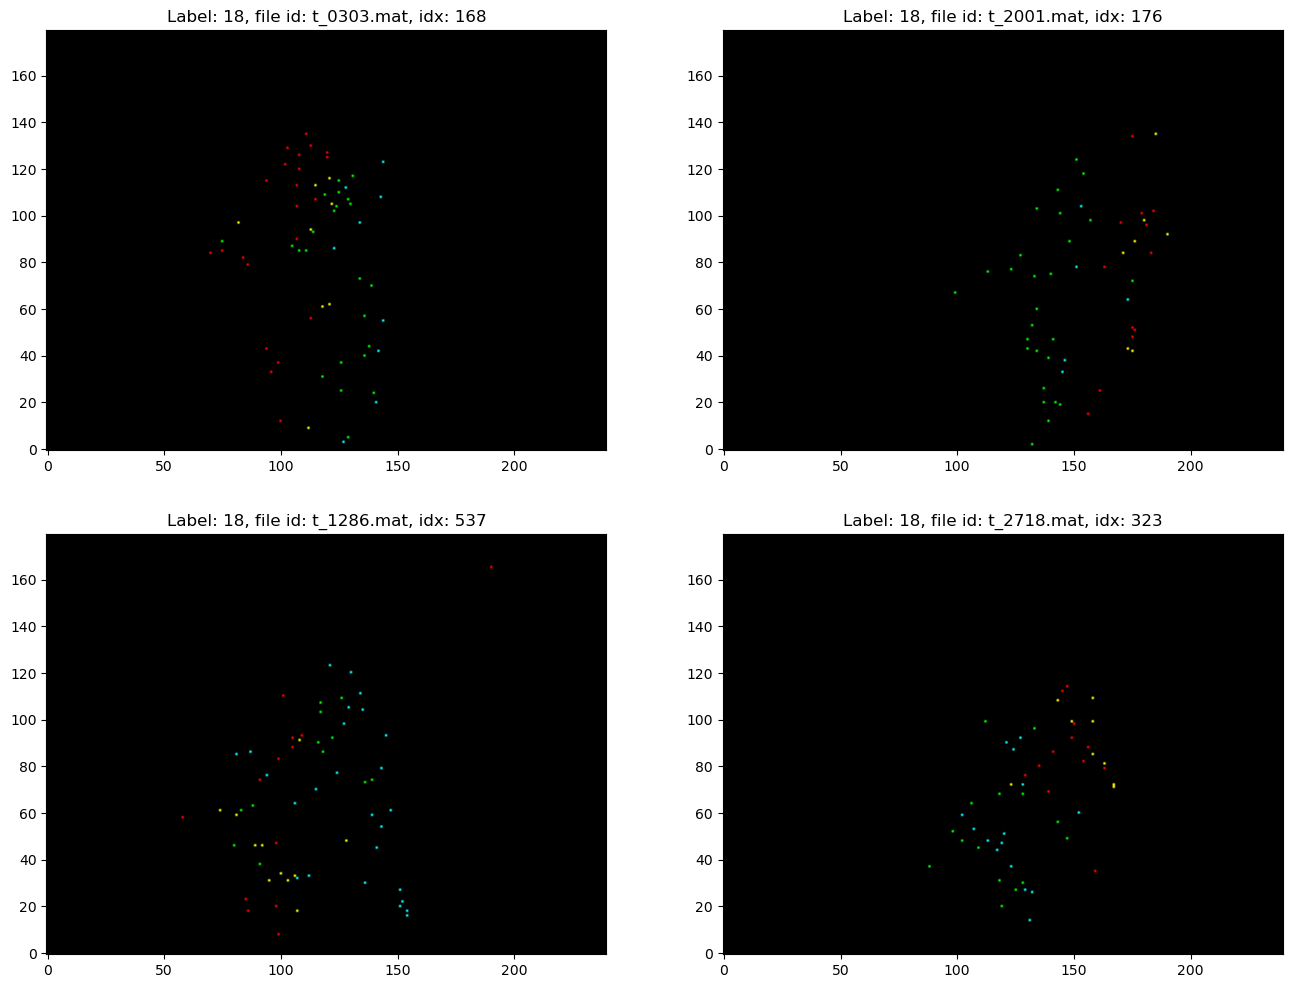

19


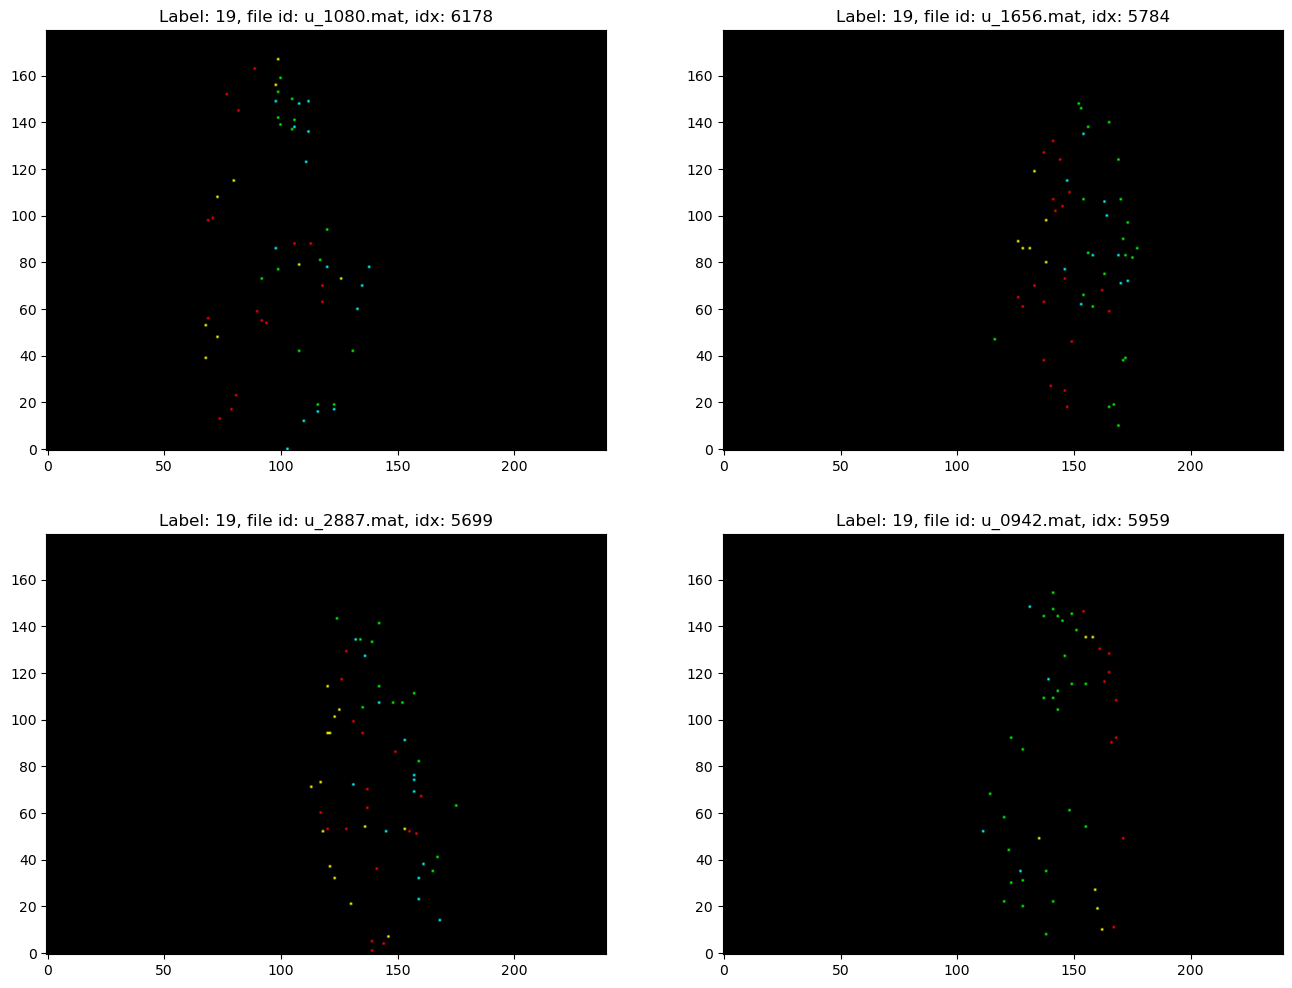

20


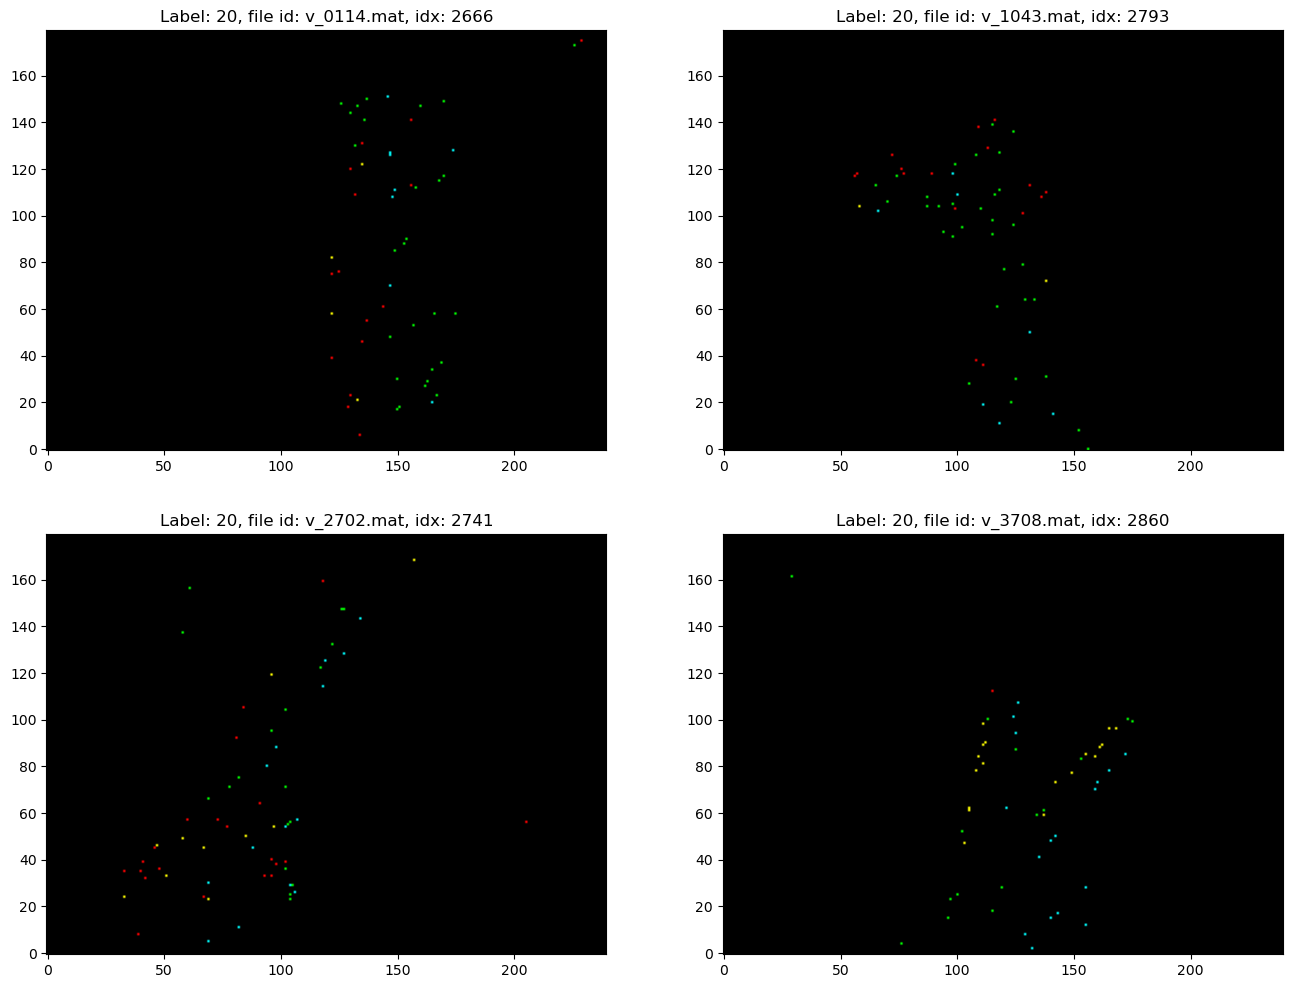

21


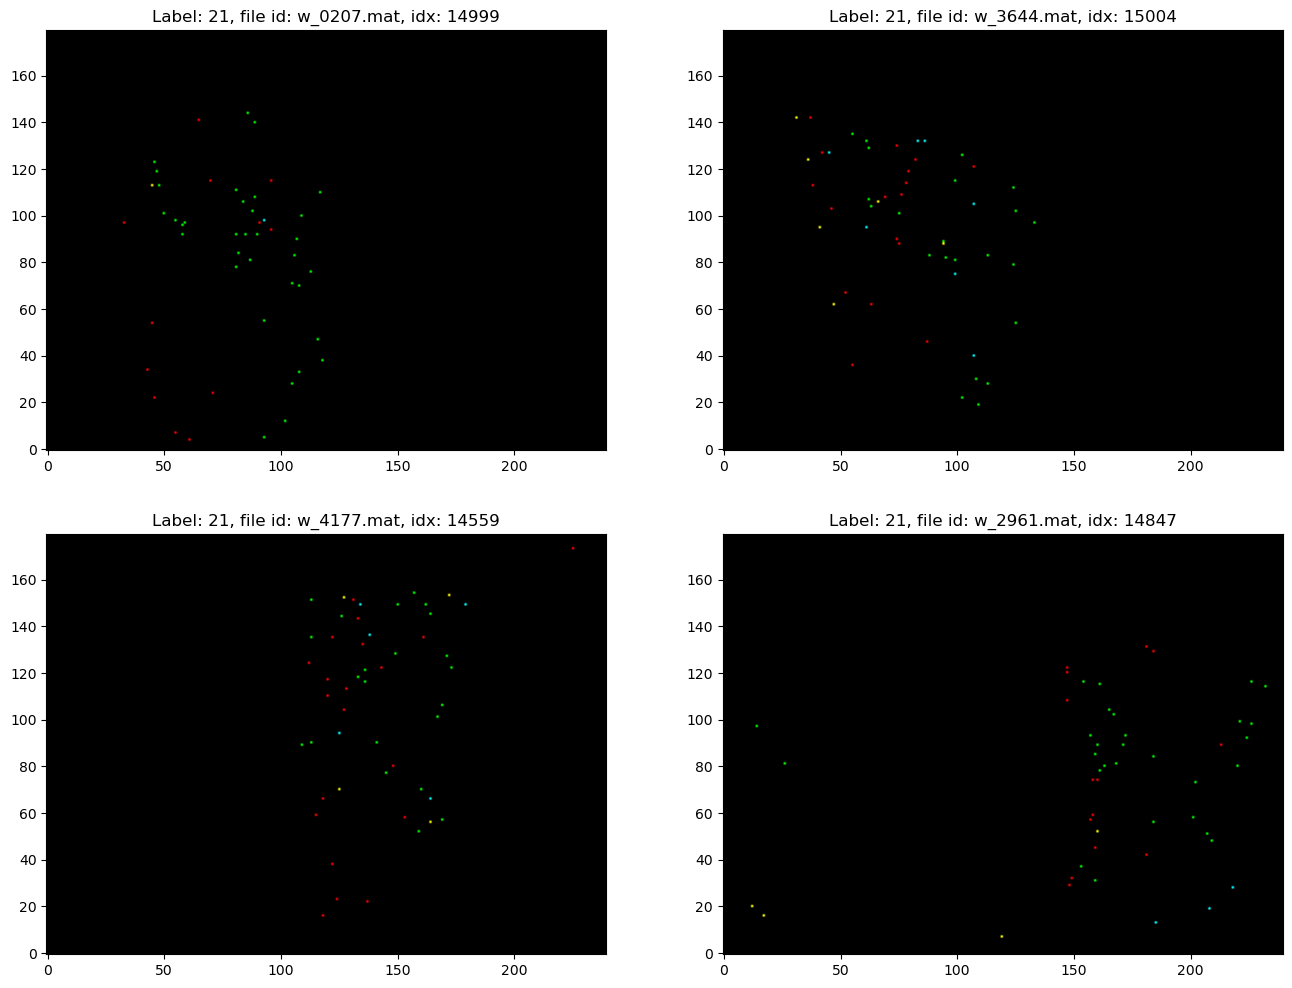

22


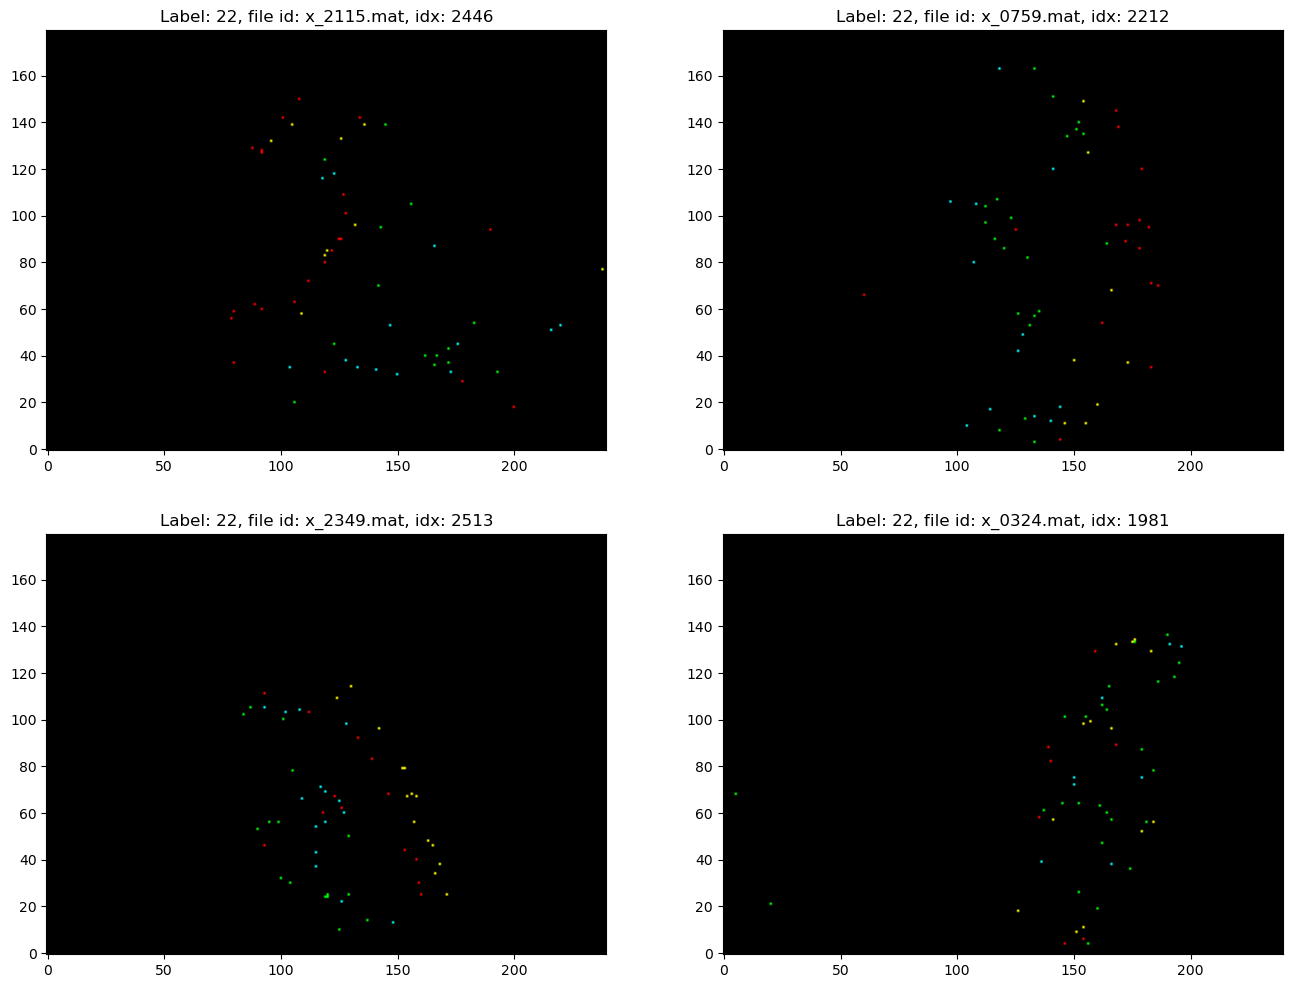

23


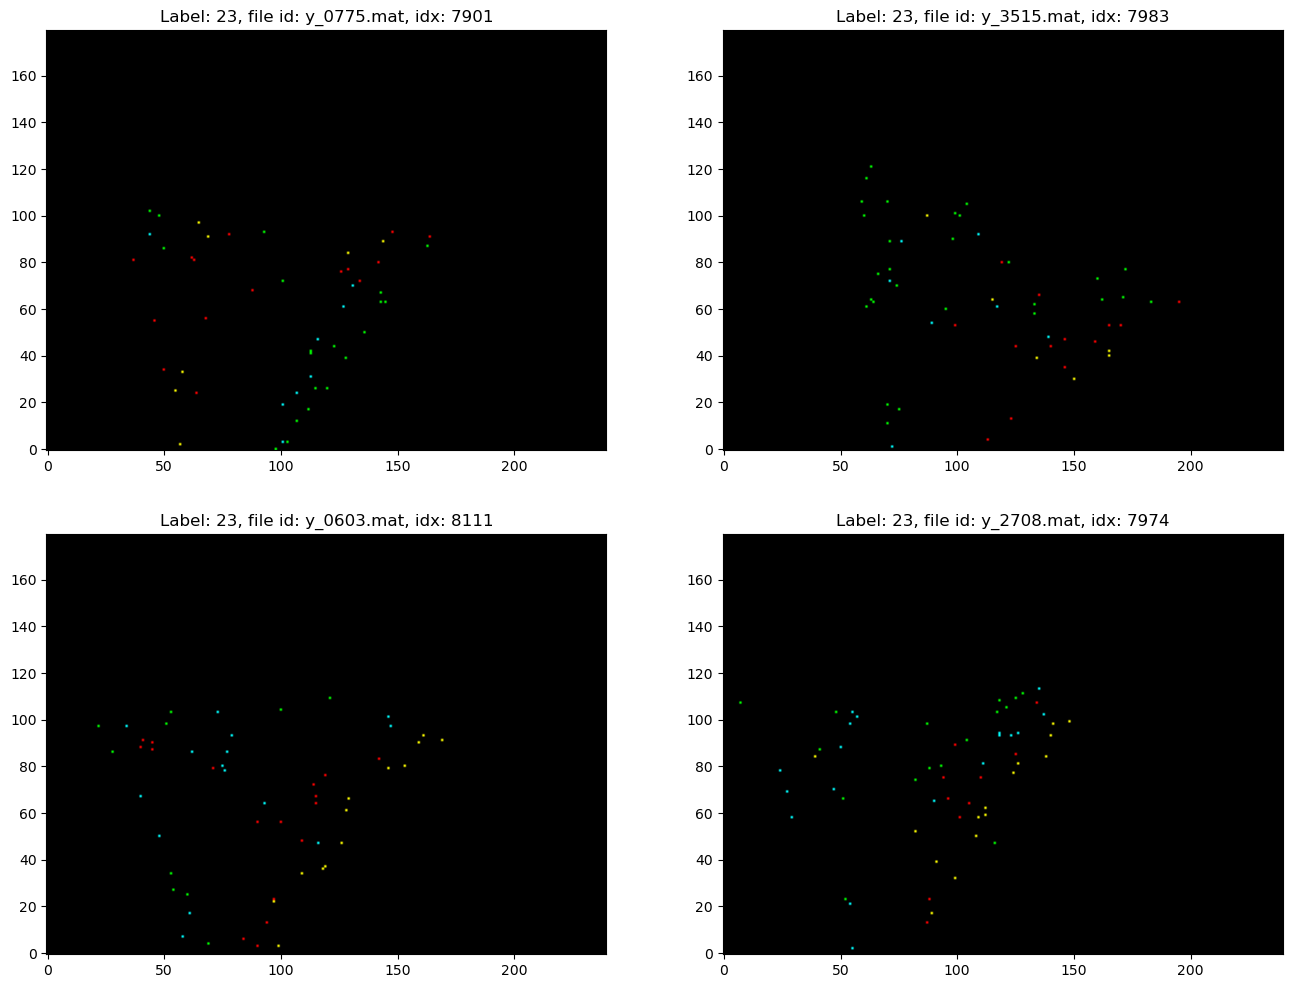

In [26]:
n = 2
m = 2
with torch.no_grad():
    for u in unique:
        fig, axs = plt.subplots(n, m, figsize=(m*8,n*6))
        print(u)

        for i in range(n):
            for j in range(m):
                
                indices = np.where(ys == u)[0]
                idx = np.random.choice(indices)
                
                data = ds[idx]
                
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
                data = data.to(device)
                out, vox = model(data)
                label = torch.argmax(out, dim=1)
                if label != u:
                    print("Wrong label")
                rep = create_image(vox)
                axs[i,j].imshow(rep.permute(1,2,0))
                axs[i,j].invert_yaxis()
                axs[i,j].set_title(f"Label: {label.item()}, file id: {data.file_id}, idx: {idx}")

        plt.show()
